# Classification (clean up from classification notebook)

## Import libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import re

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

## import model objects
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit

In [2]:
#seed = np.random.seed(22)
seed = 1

## Read files

In [3]:
df = pd.read_csv('../Data/dataset_others_class.csv')
df = df.rename(columns={'F_Close_pred_class':'Prediction'})
df

Date  CADUSD=X_Open  CADUSD=X_Close  CADUSD=X_High  \
0     2019-11-26 00:00:00+00:00       0.751665        0.751705       0.752842   
1     2019-11-27 00:00:00+00:00       0.753597        0.753636       0.754205   
2     2019-11-29 00:00:00+00:00       0.753125        0.753029       0.753211   
3     2019-12-02 00:00:00+00:00       0.752734        0.752791       0.753296   
4     2019-12-03 00:00:00+00:00       0.751552        0.751710       0.752899   
...                         ...            ...             ...            ...   
1232  2024-10-22 00:00:00+00:00       0.722883        0.722883       0.723877   
1233  2024-10-23 00:00:00+00:00       0.723788        0.723788       0.723809   
1234  2024-10-24 00:00:00+00:00       0.722716        0.722716       0.724008   
1235  2024-10-25 00:00:00+00:00       0.721850        0.721850       0.722648   
1236  2024-10-28 00:00:00+00:00       0.719652        0.719652       0.720326   

      CADUSD=X_Low  CADUSD=X_Volume  CADUSD=X_Change  CADUSD=X_Gain  \
0         0.750999              0.0        -0.000418       0.000000   
1         0.752502              0.0         0.001932       0.001932   
2         0.751145              0.0        -0.000607       0.000000   
3         0.751569              0.0        -0.000238       0.000000   
4         0.750728              0.0        -0.001081       0.000000   
...            ...              ...              ...            ...   
1232      0.722684              0.0        -0.001776       0.000000   
1233      0.721433              0.0         0.000905       0.000905   
1234      0.721480              0.0        -0.001072       0.000000   
1235      0.720170              0.0        -0.000866       0.000000   
1236      0.719031              0.0        -0.002197       0.000000   

      CADUSD=X_Loss  CADUSD=X_Avg_Gain  ...      F_RSI  F_k_percent  \
0          0.000418           0.000289  ...  62.087549    73.913071   
1          0.000000           0.000427  ...  67.610216    89.583482   
2          0.000607           0.000427  ...  62.910674    81.250149   
3          0.000238           0.000419  ...  57.178300    70.833433   
4          0.001081           0.000419  ...  45.657569    45.833433   
...             ...                ...  ...        ...          ...   
1232       0.001776           0.000308  ...  63.192190    91.764633   
1233       0.000000           0.000245  ...  59.825069    80.219848   
1234       0.001072           0.000245  ...  67.105734    98.850548   
1235       0.000866           0.000245  ...  56.038726    72.631549   
1236       0.002197           0.000245  ...  67.090123    97.894690   

      F_r_percent    F_MACD  F_MACD_EMA     F_ROC         F_PVT  \
0      -26.086929  0.006892    0.002249 -0.331855  2.394865e+06   
1      -10.416518  0.019164    0.005663  0.220269  2.768411e+06   
2      -18.749851  0.025755    0.009711  0.221244  2.710846e+06   
3      -29.166567  0.027163    0.013223  2.270145  2.505366e+06   
4      -54.166567  0.019687    0.014522  1.137661  1.963927e+06   
...           ...       ...         ...       ...           ...   
1232    -8.235367  0.063288    0.007636  6.315788  6.779642e+07   
1233   -19.780152  0.071755    0.020460  4.635769  6.762839e+07   
1234    -1.149452  0.091931    0.034754  7.149667  6.835647e+07   
1235   -27.368451  0.093129    0.046429  4.237286  6.776479e+07   
1236    -2.105310  0.116938    0.060531  6.460670  7.041972e+07   

      F_Bollinger_Upper  F_Bollinger_Lower  Prediction  
0              9.188927           8.586074           1  
1              9.183159           8.647842           0  
2              9.165730           8.712270           0  
3              9.172619           8.717381           0  
4              9.166840           8.712161           1  
...                 ...                ...         ...  
1232          11.195281          10.306719           0  
1233          11.223237          10.297763           1  
1234          11.282170       

In [4]:
tickers = []
for col in df.columns:
    if '_RSI' in col:
        tickers.append(col.split('_')[0])

tickers.pop()
tickers

['CADUSD=X', 'GM', 'JCI', 'TM', 'TRYUSD=X', '^IXIC']

In [5]:
## Remove open, close, high, low, vol columns
open_cols = [col for col in df.columns if '_Open' in col]
close_cols = [col for col in df.columns if '_Close' in col]
high_cols = [col for col in df.columns if '_High' in col]
low_cols = [col for col in df.columns if '_Low' in col]
vol_cols = [col for col in df.columns if '_Volume' in col]

df = df.drop(columns=open_cols)
df = df.drop(columns=close_cols)
df = df.drop(columns=high_cols)
df = df.drop(columns=low_cols)
df = df.drop(columns=vol_cols)

In [6]:
tickers

['CADUSD=X', 'GM', 'JCI', 'TM', 'TRYUSD=X', '^IXIC']

## Extract F columns and one of other tickers

In [7]:
def extract_cols(df, ticker: str):
    F_cols = [col for col in df.columns if 'F_' in col]
    cols = F_cols.copy()

    if ticker != 'F':
        for col in df.columns:
            if col == 'CADUSD=X_PVT' or col == 'TRYUSD=X_PVT':
                pass
            elif ticker in col:
                cols.append(col)
            
    cols.append('Prediction')
    df_final = df[cols].copy()
    df_final = df_final.dropna()
            
    return df_final

In [8]:
def extract_train_test_set(X_train, X_test, y_train, y_test, ticker: str):
    F_cols = [col for col in df.columns if 'F_' in col]
    cols = F_cols.copy()

    if ticker != 'F':
        for col in df.columns:
            if col == 'CADUSD=X_PVT' or col == 'TRYUSD=X_PVT':
                pass
            elif ticker in col:
                cols.append(col)
            
    #cols.append('Prediction')
    X_tr = X_train[cols]
    X_t = X_test[cols]
    y_tr = y_train
    y_t = y_test
            
    return X_tr, X_t, y_tr, y_t

## Plot histogram for each ticker

CADUSD=X


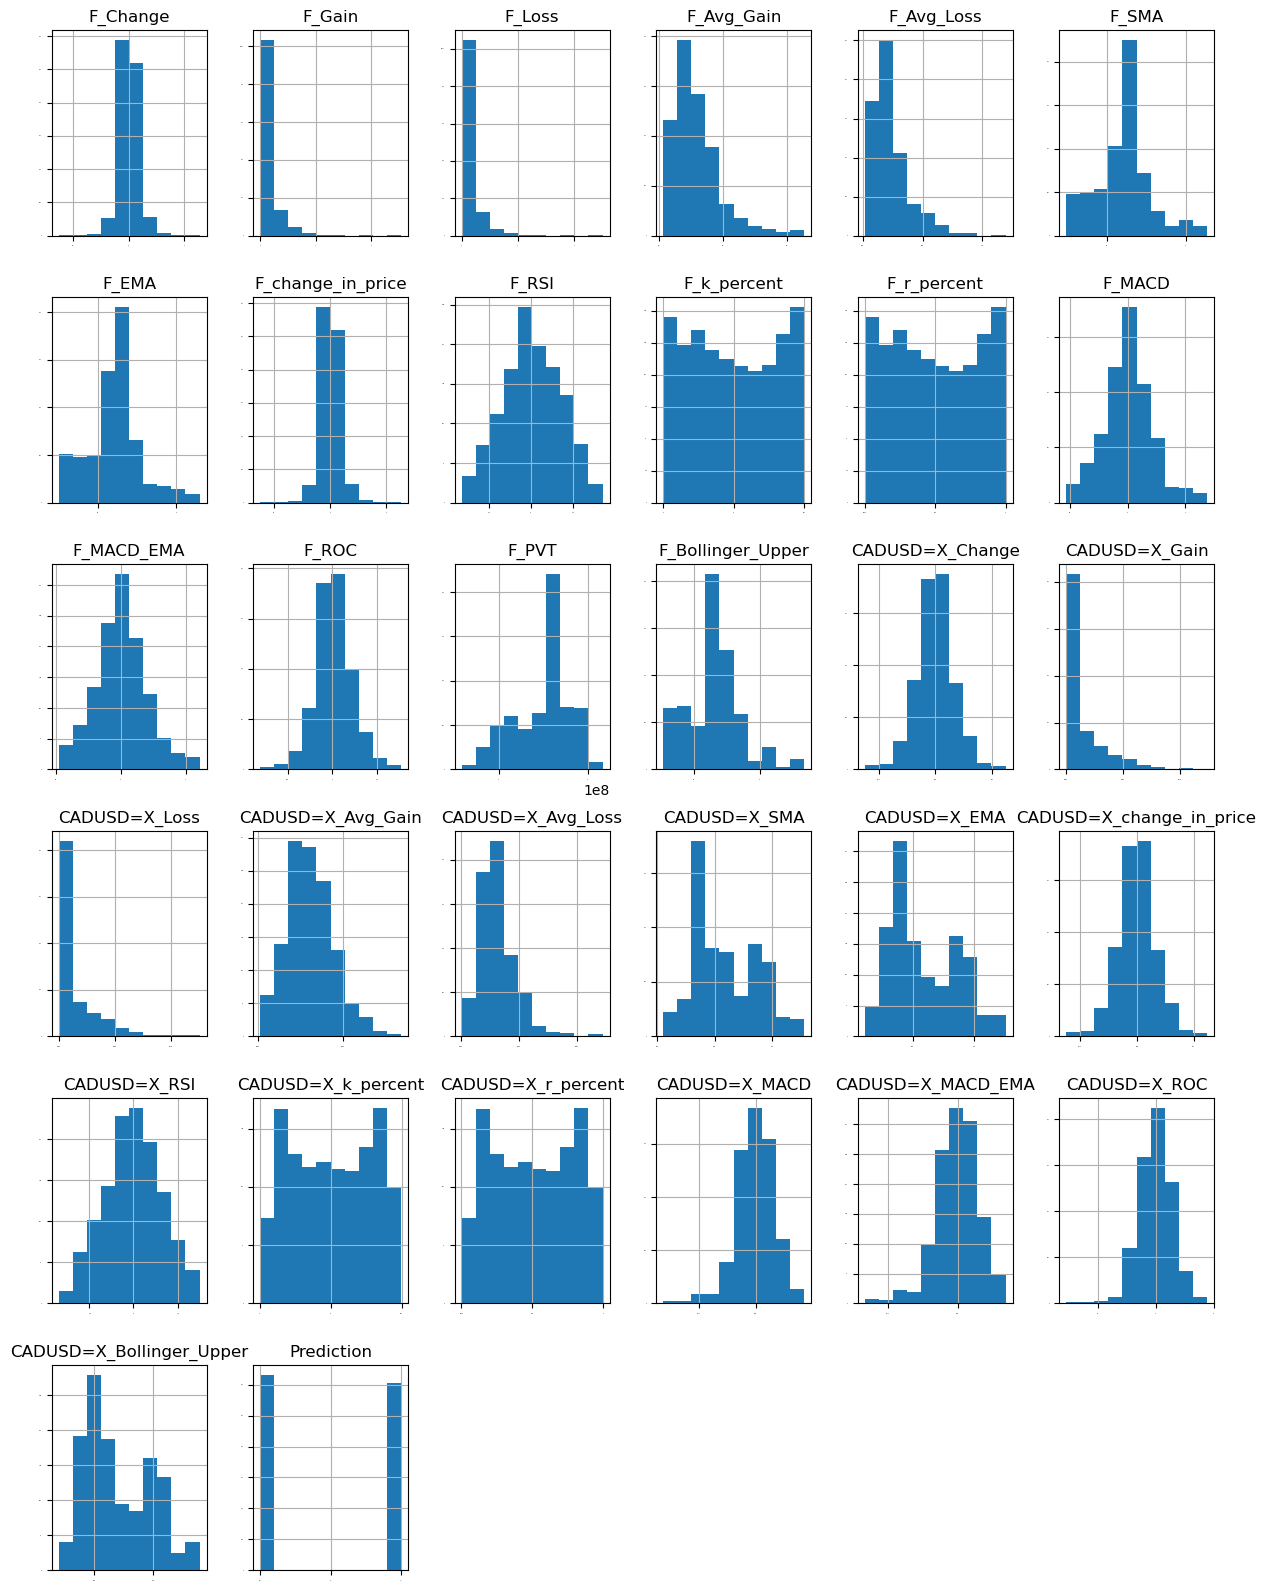

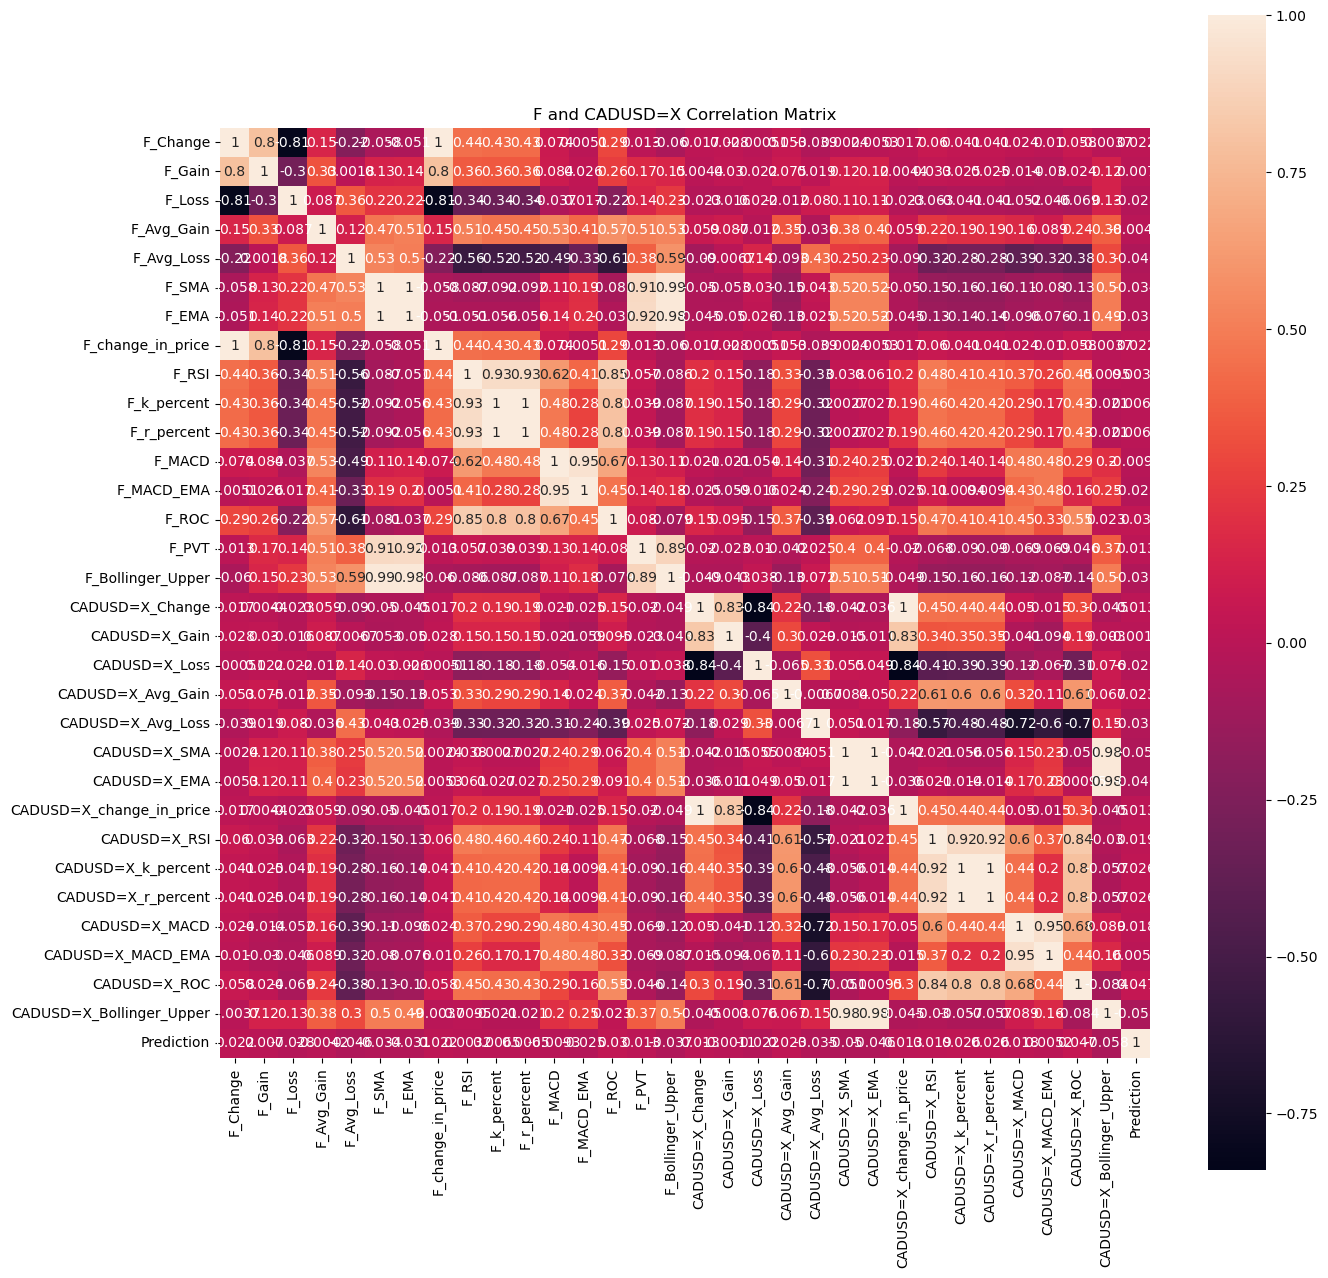

GM


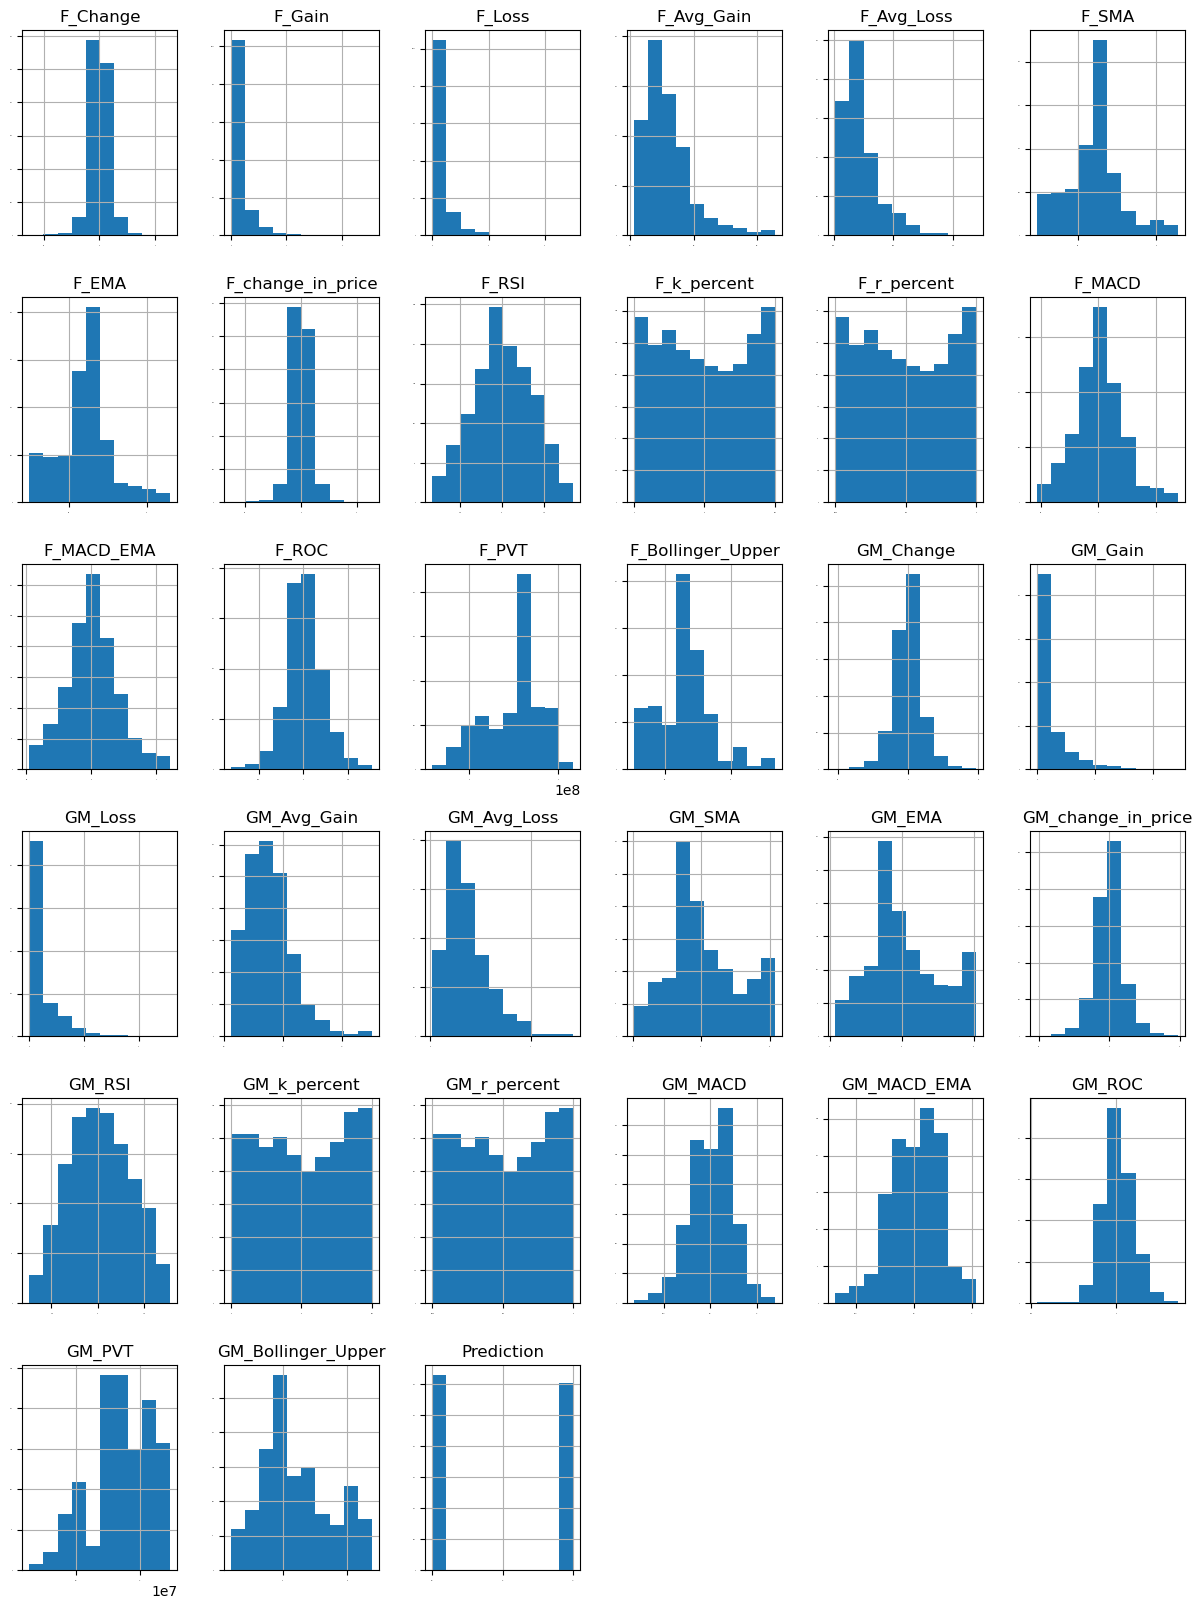

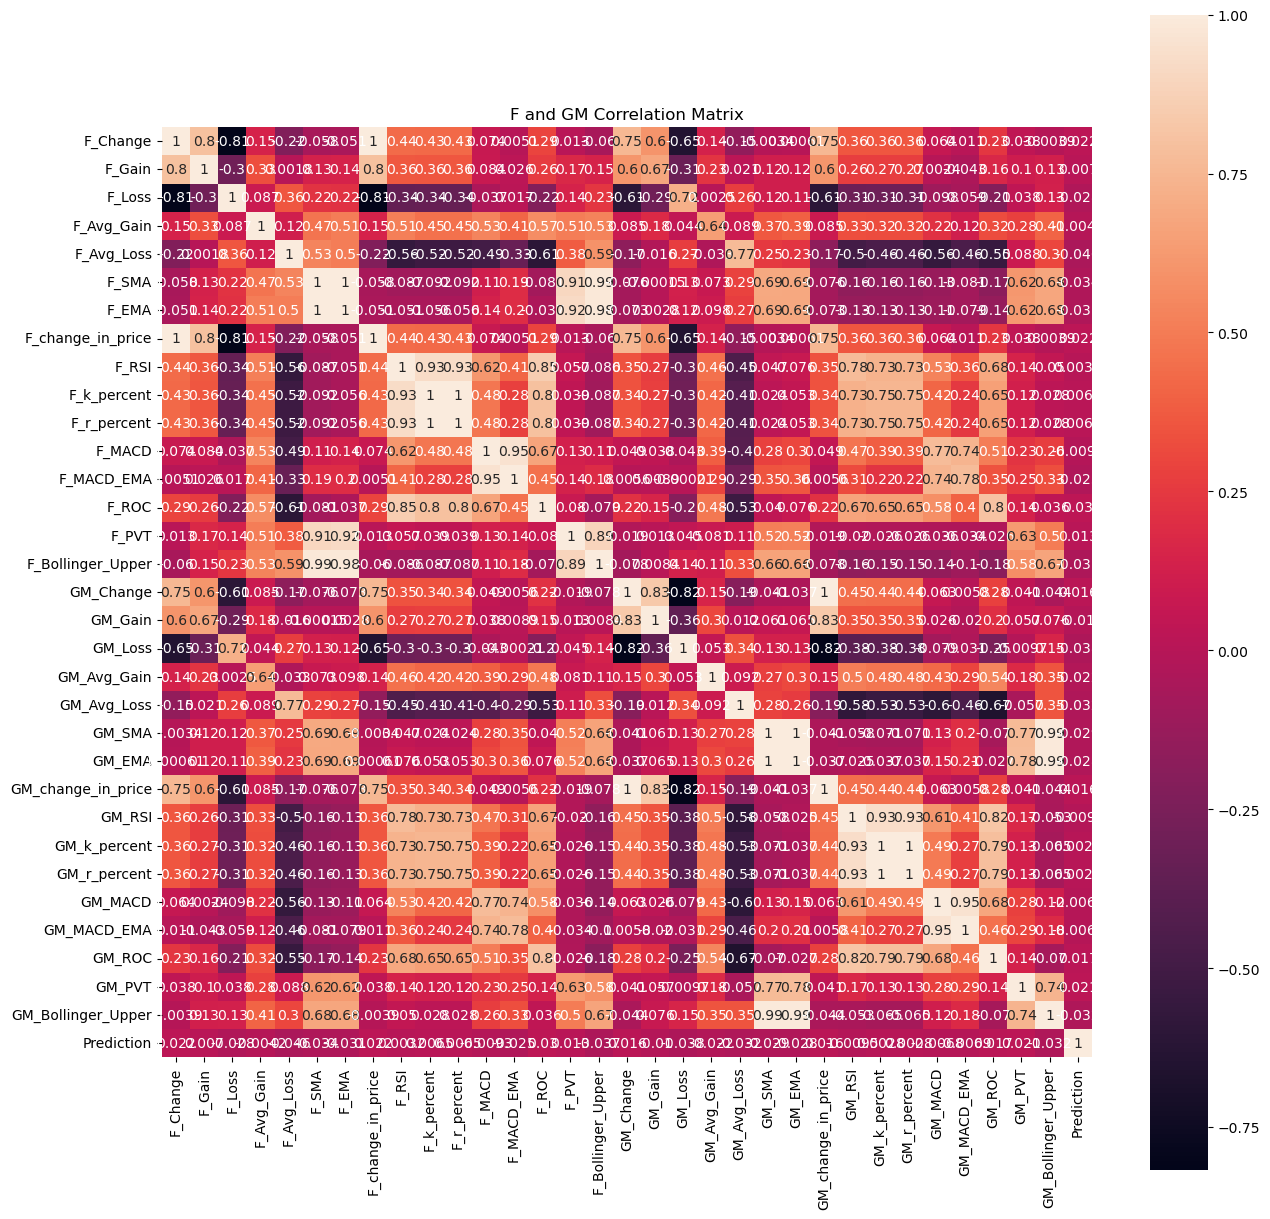

JCI


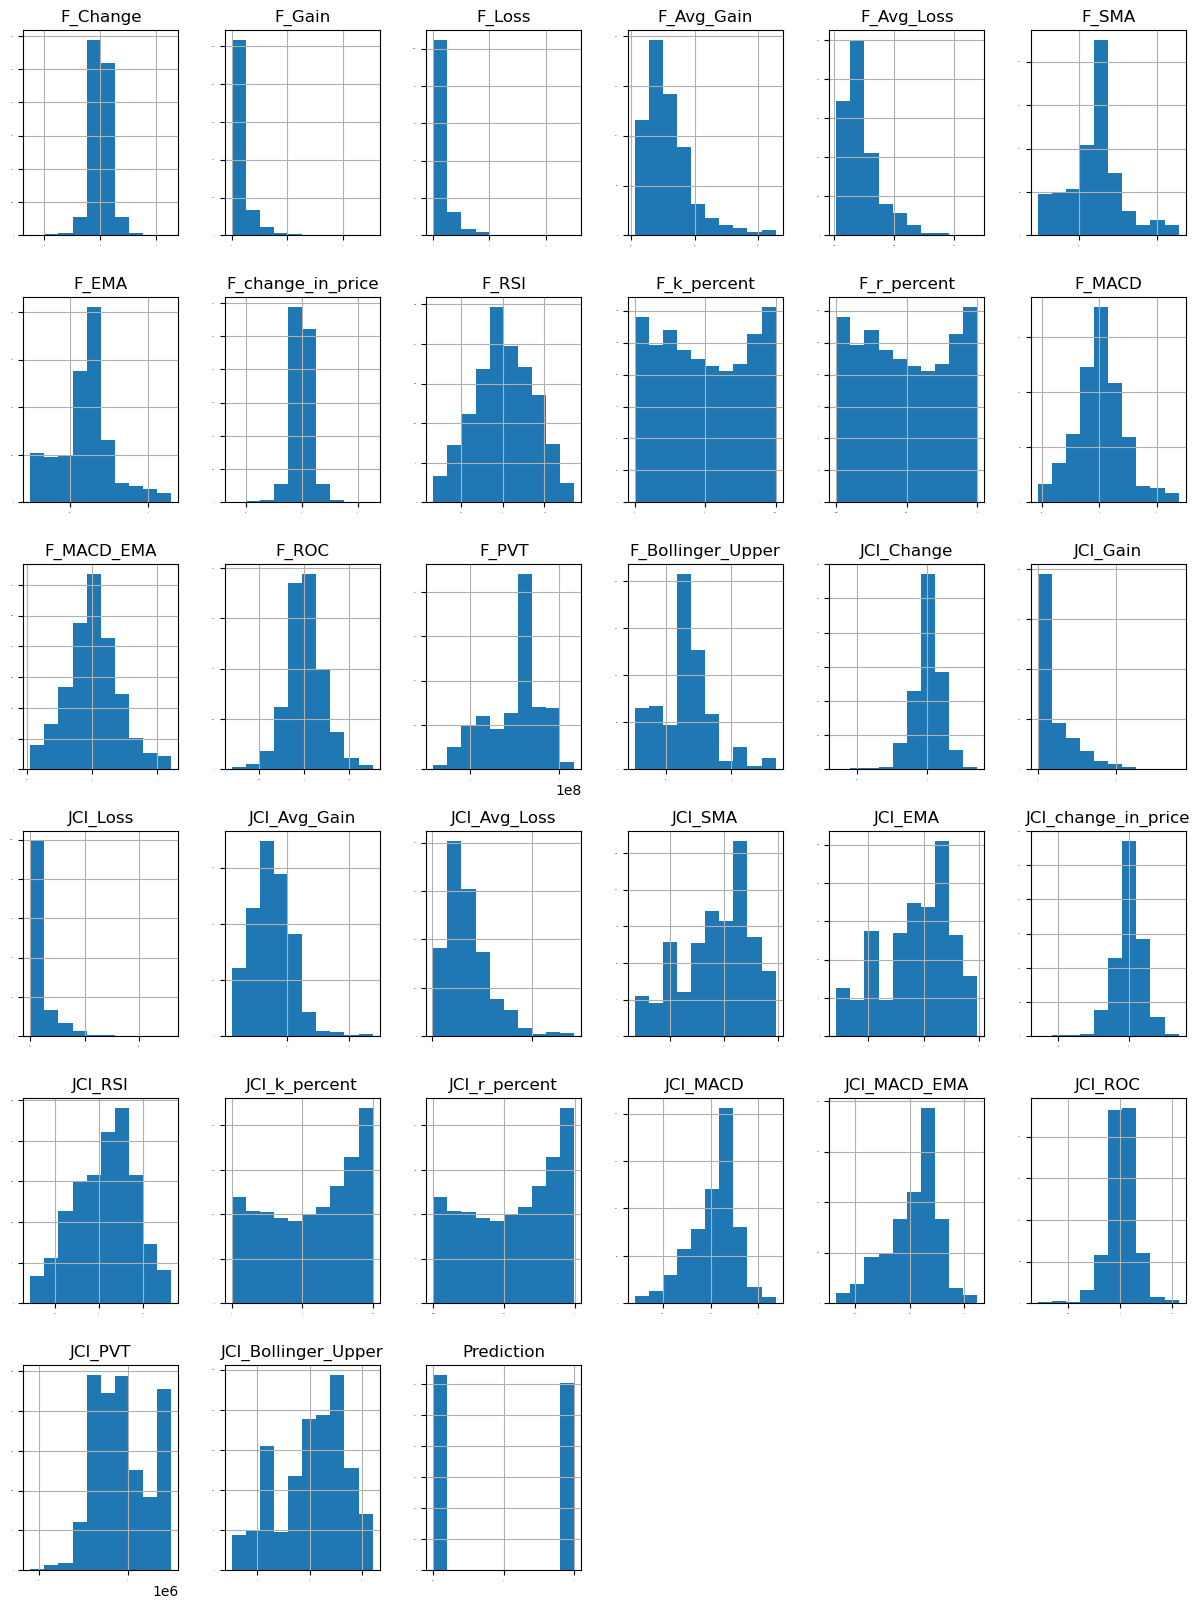

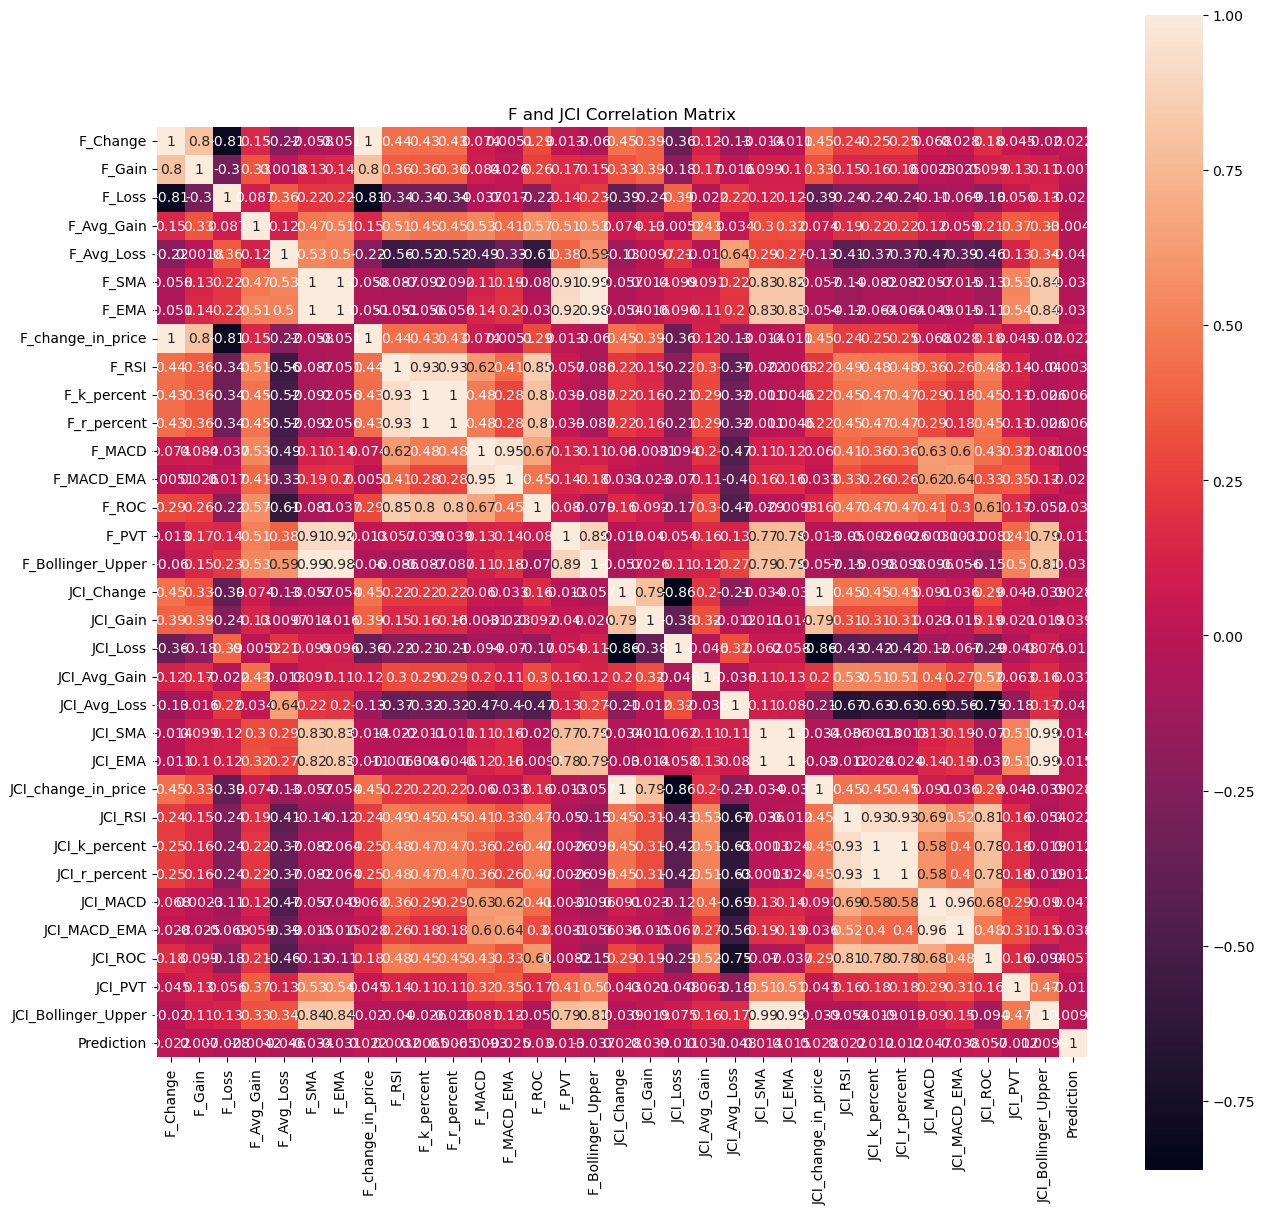

TM


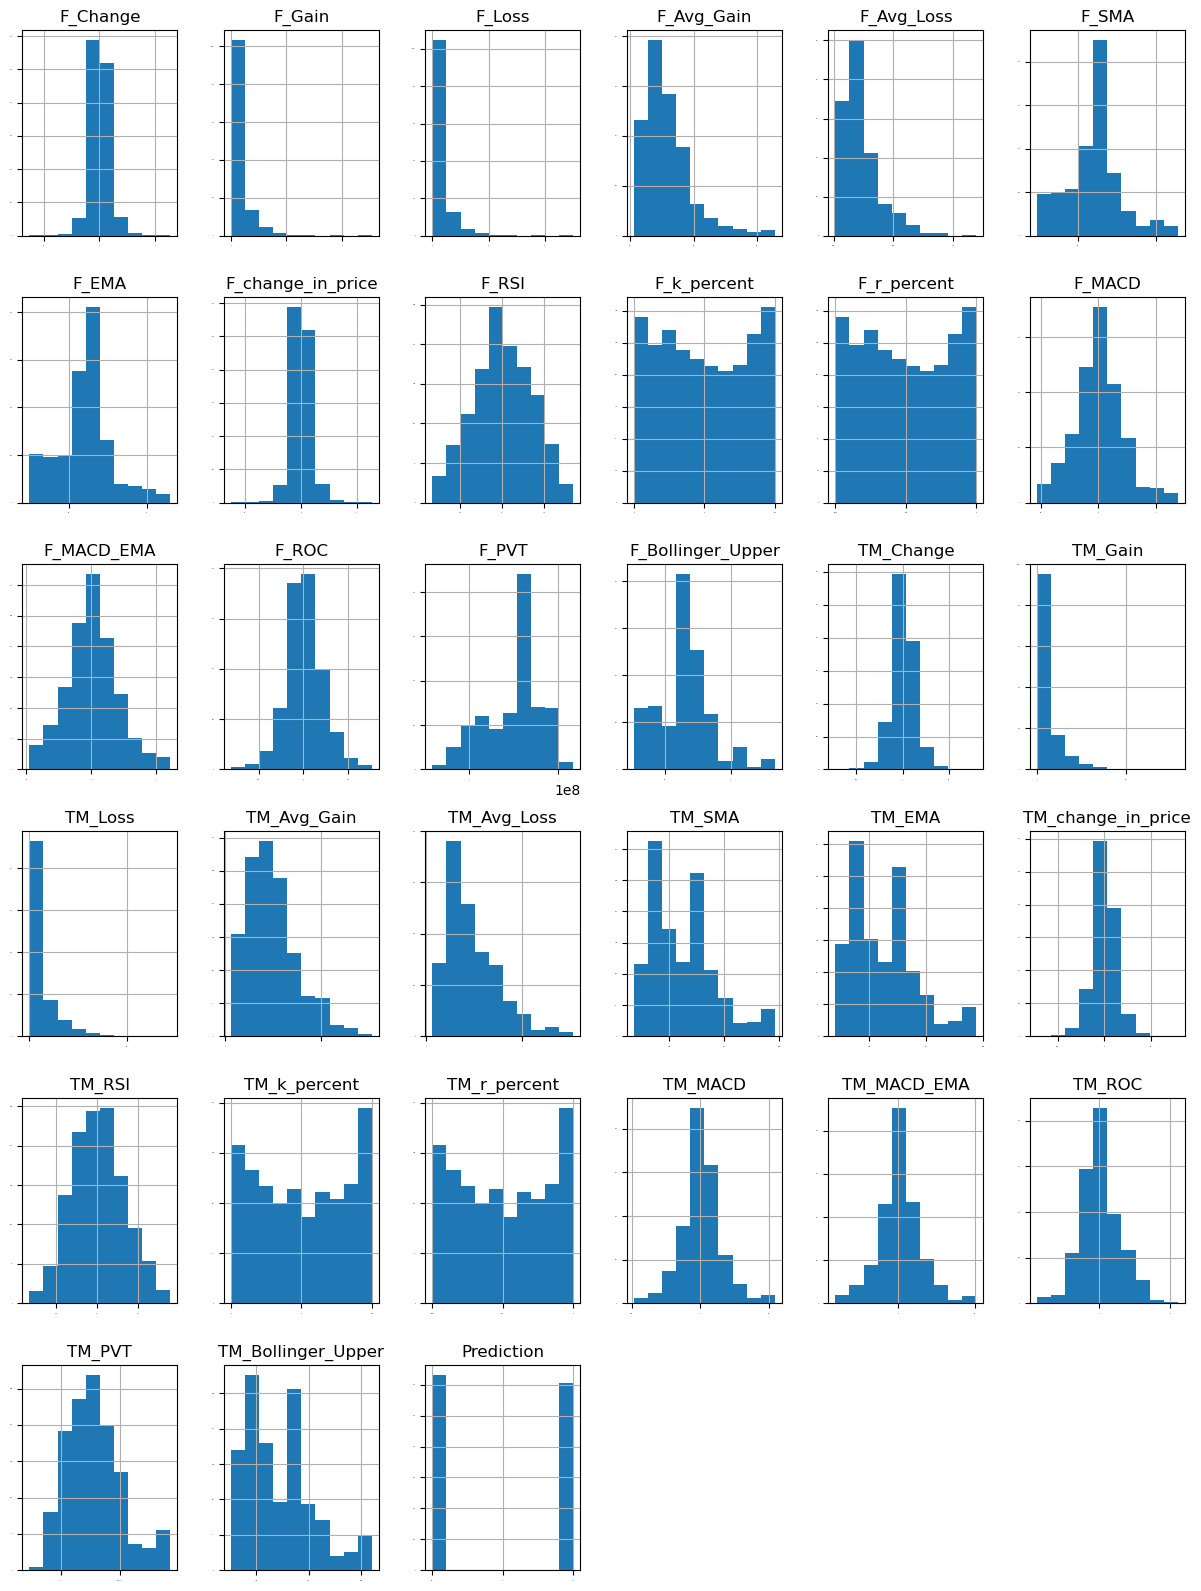

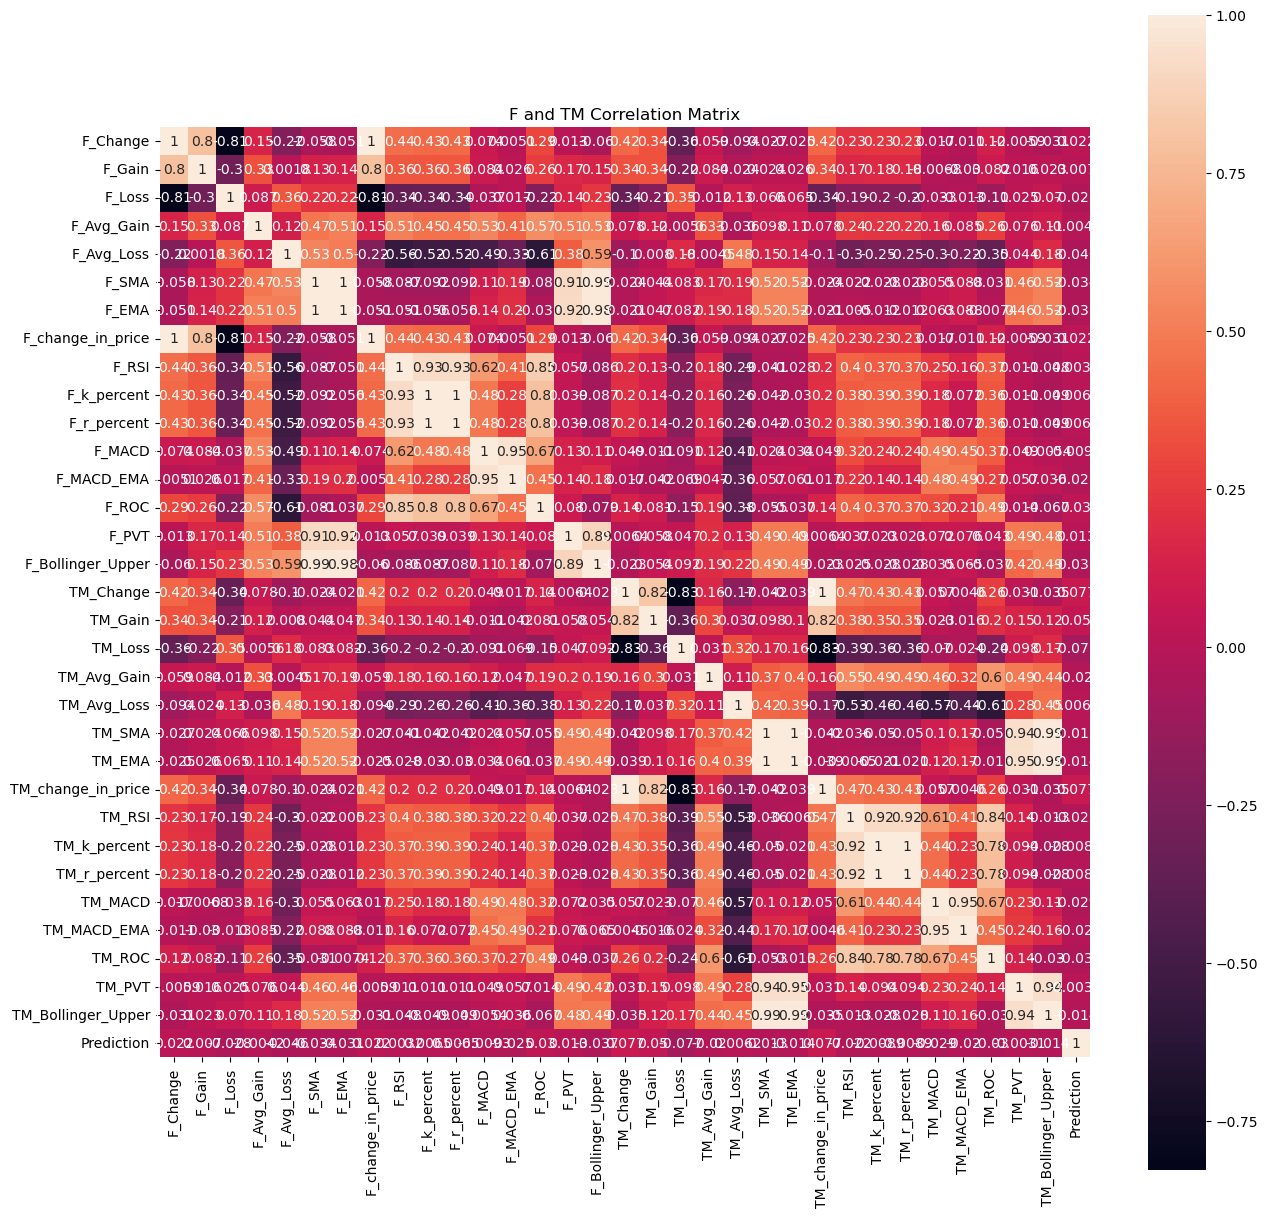

TRYUSD=X


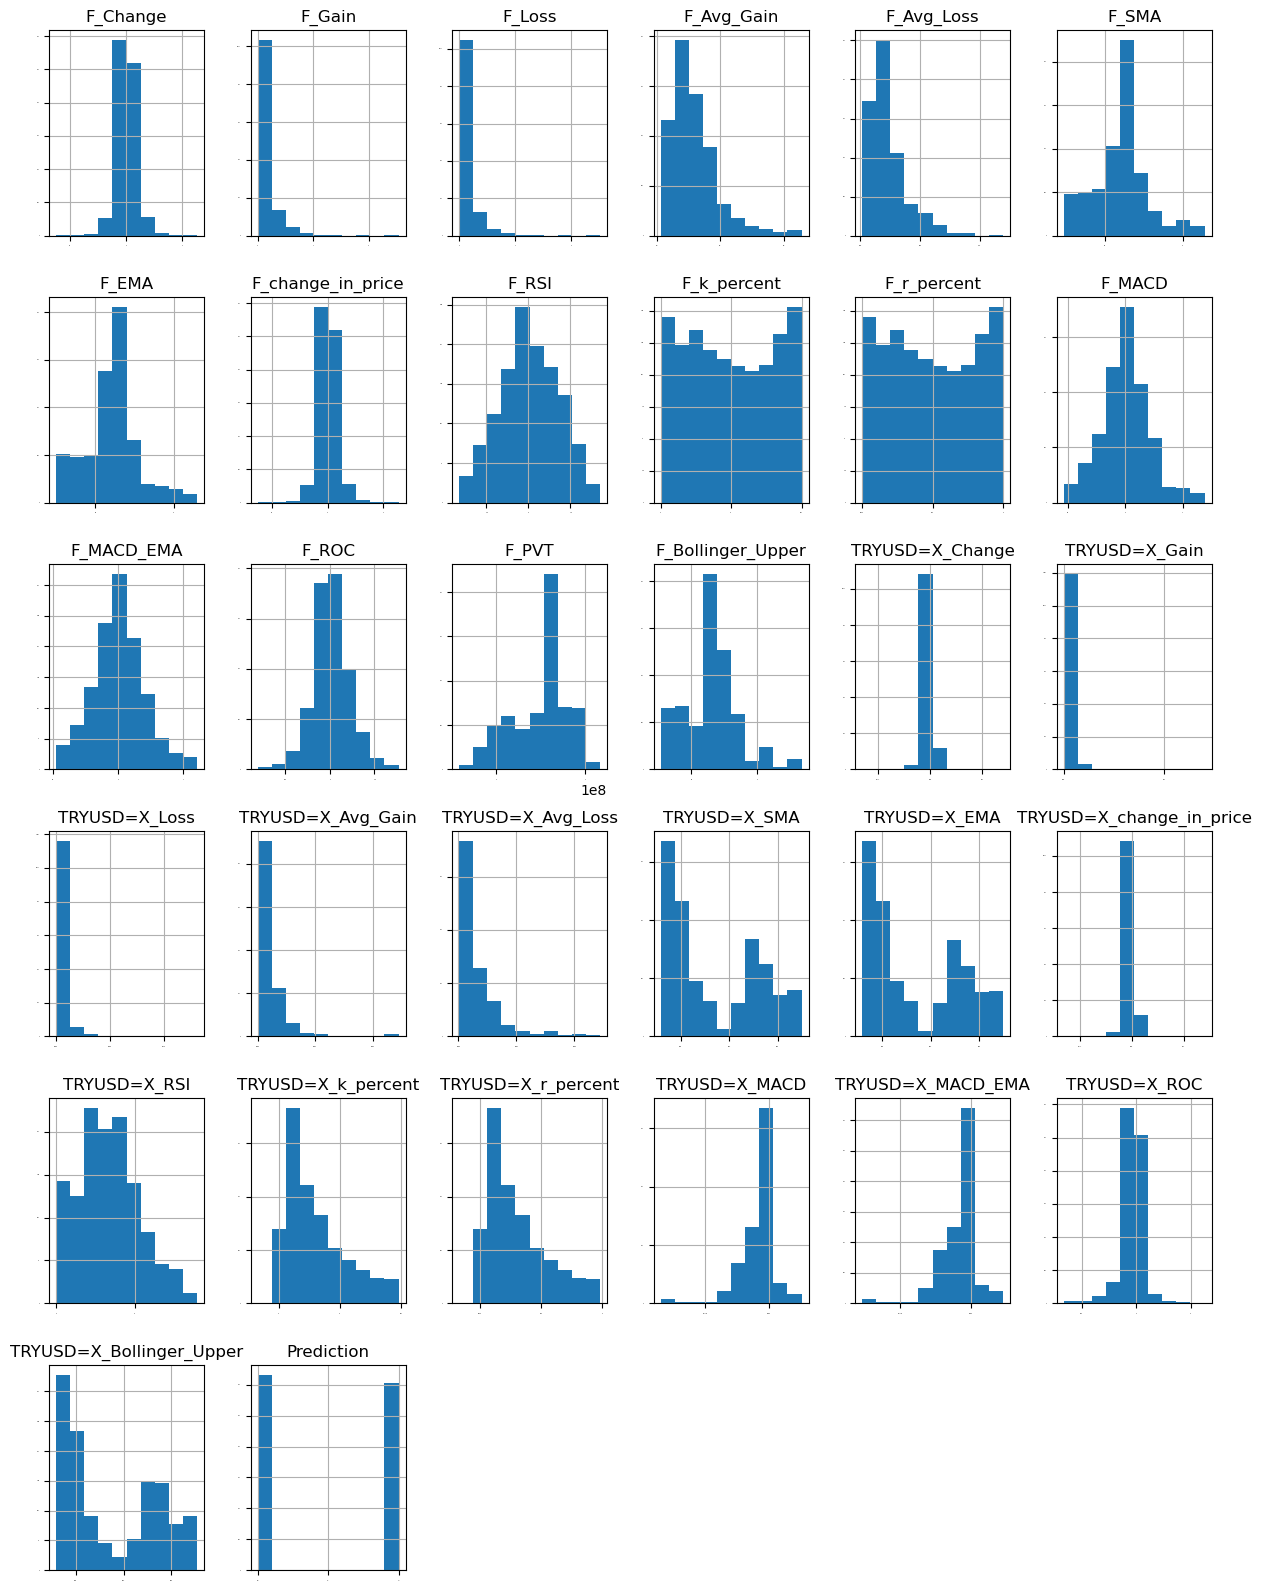

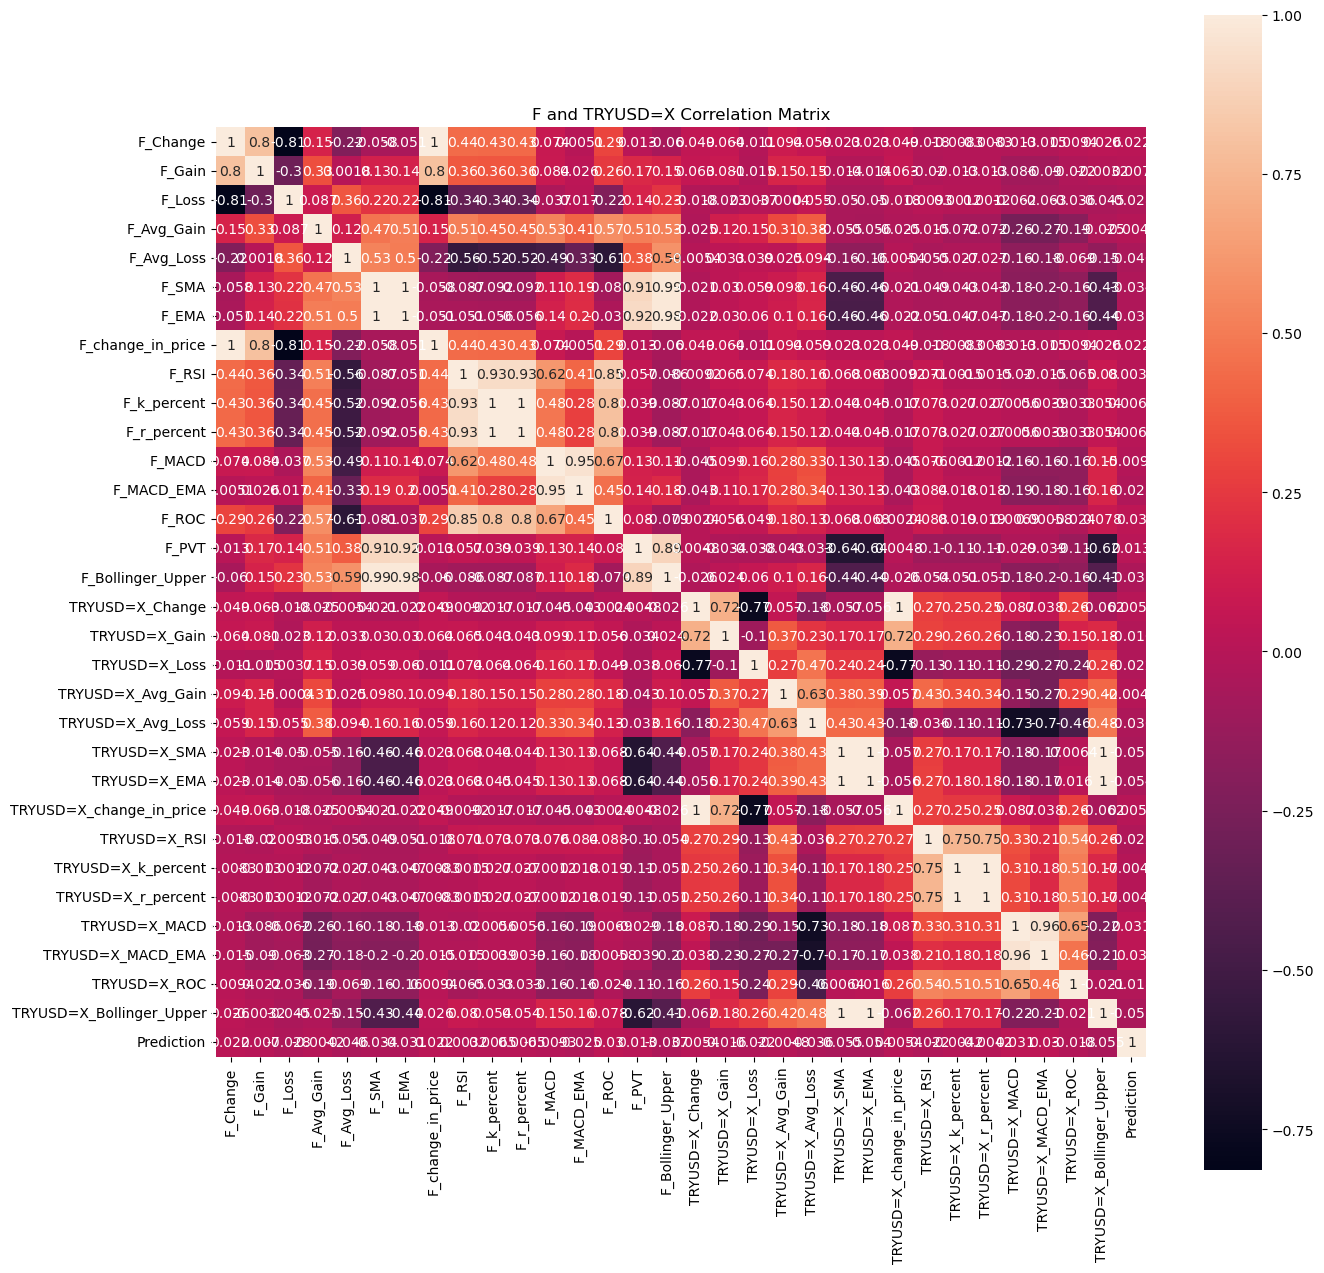

^IXIC


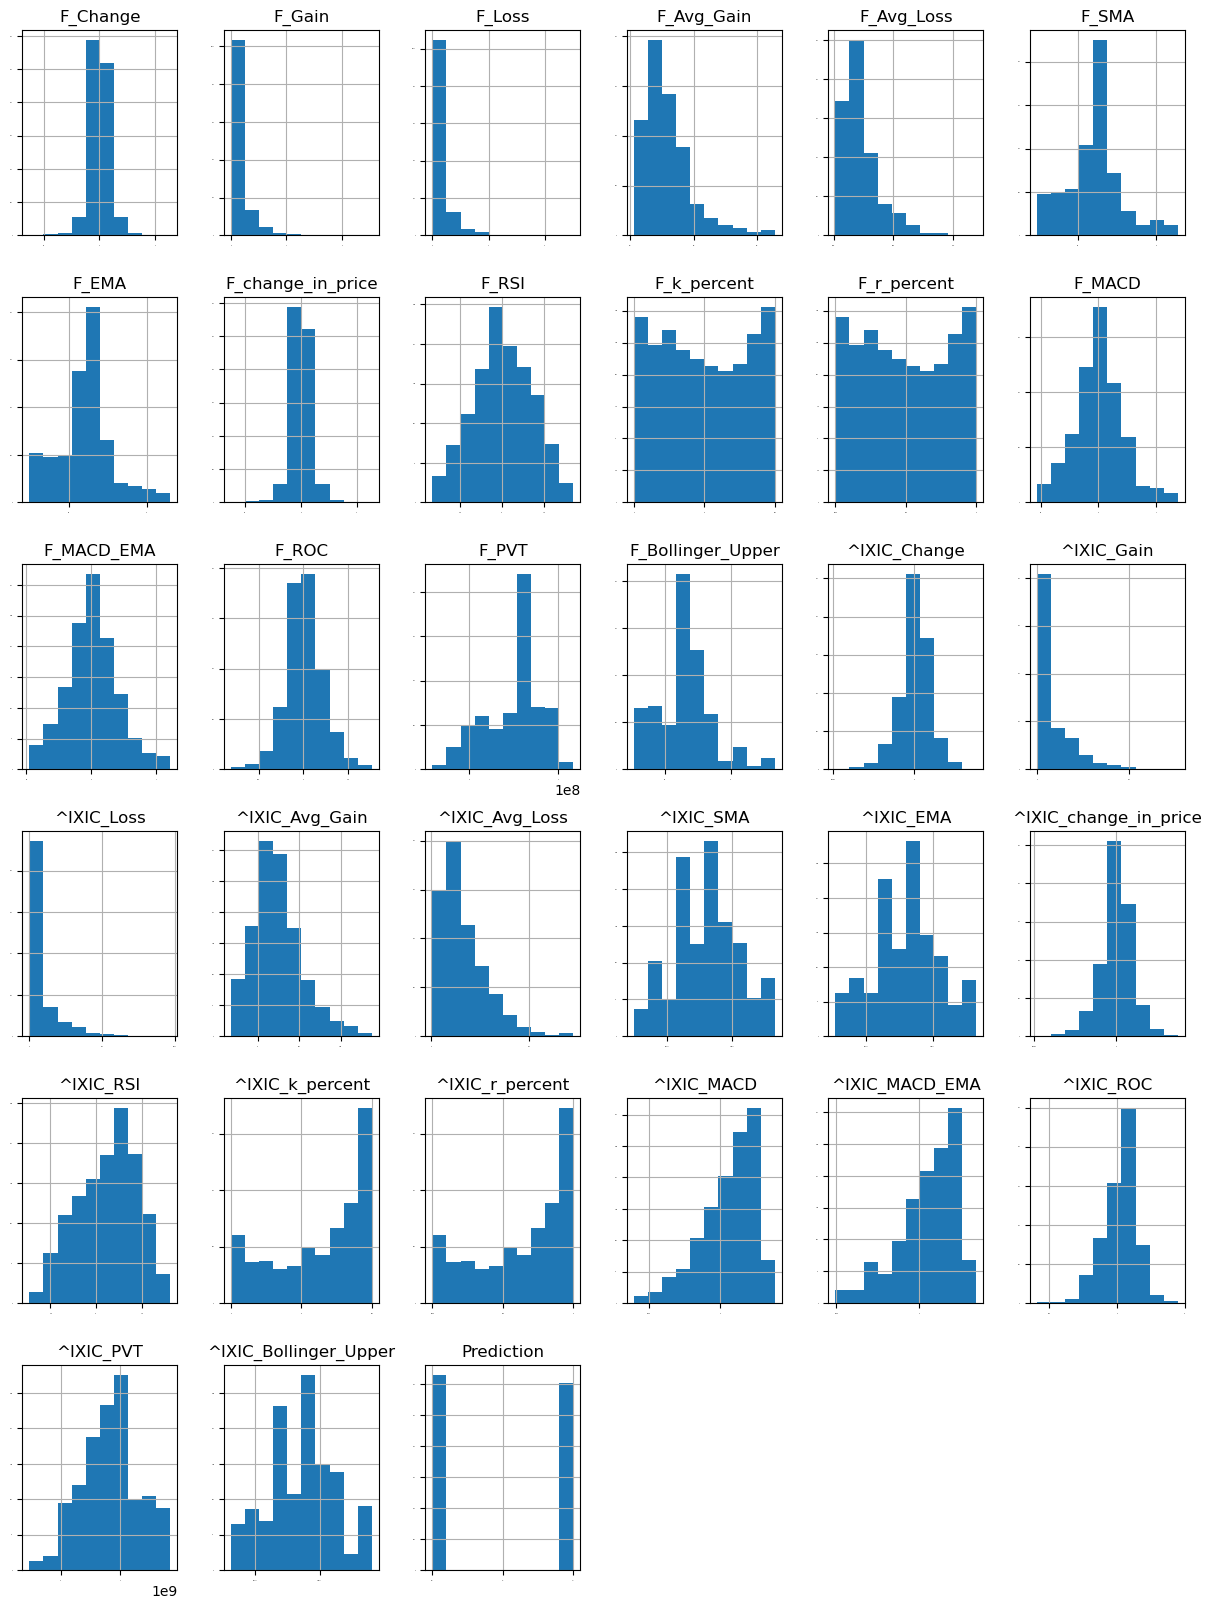

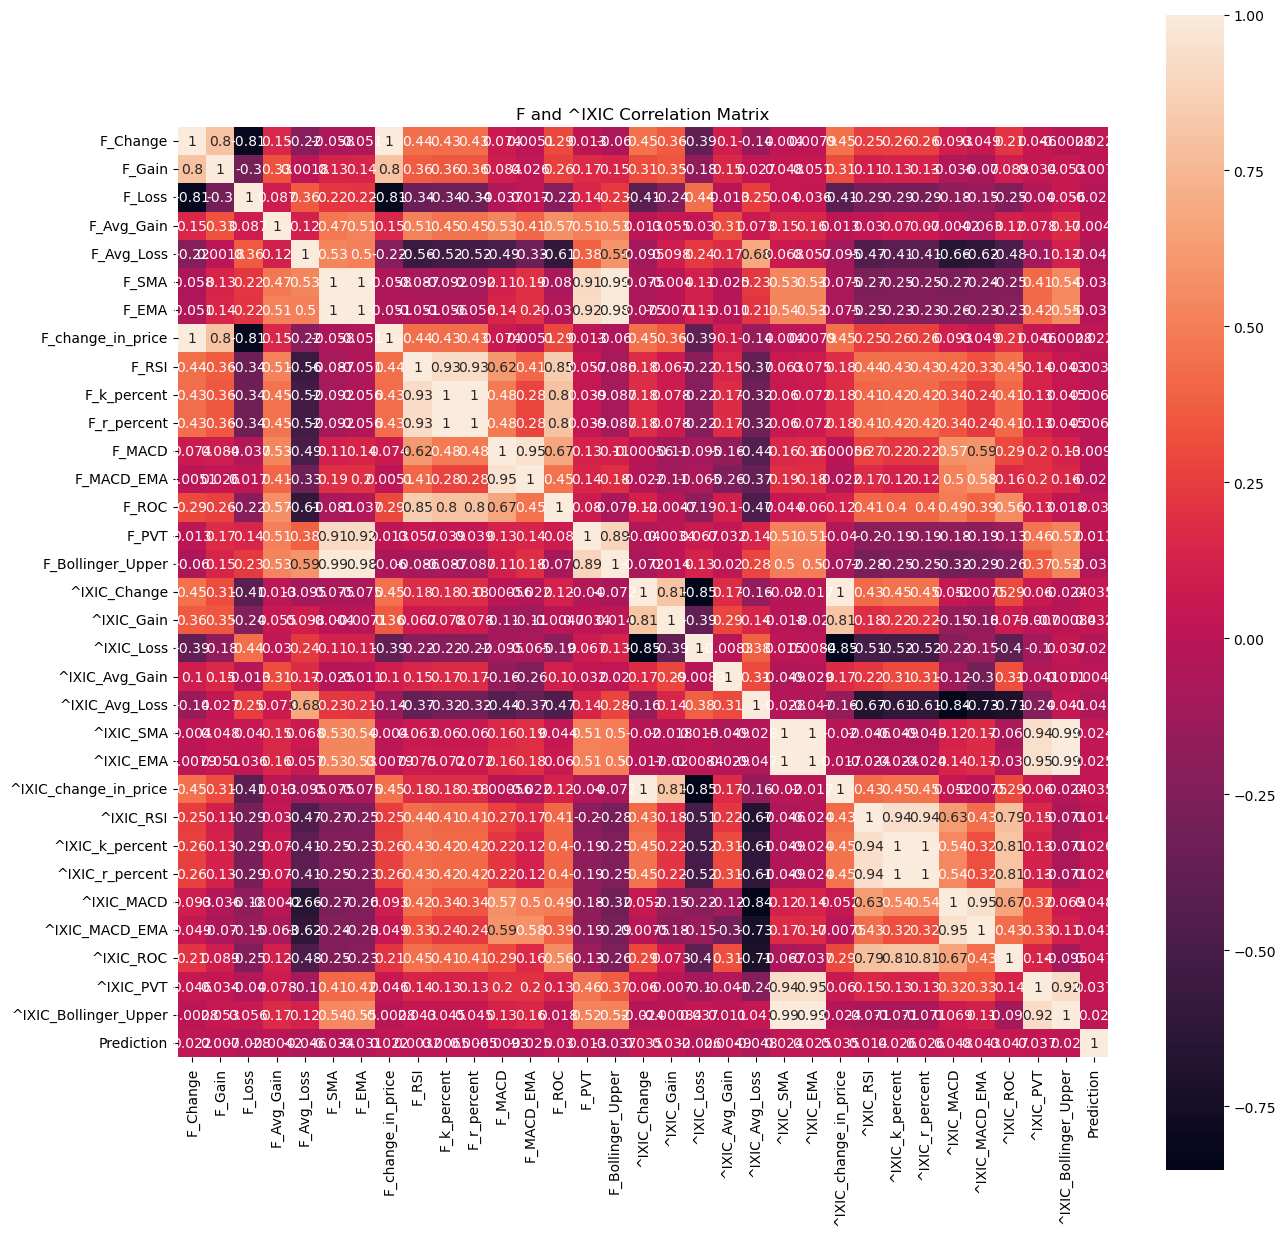

In [9]:
for t in tickers:
    print(t)
    df1 = extract_cols(df, t)
    df1.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(15,20))
    plt.show()

    correlation = df1.corr()
    plt.figure(figsize=(15,15))
    plt.title('F and ' + t + ' Correlation Matrix')
    sns.heatmap(correlation, vmax=1, square=True, annot=True)
    plt.show()

## Split train-test sets

In [10]:
df

Date  CADUSD=X_Change  CADUSD=X_Gain  \
0     2019-11-26 00:00:00+00:00        -0.000418       0.000000   
1     2019-11-27 00:00:00+00:00         0.001932       0.001932   
2     2019-11-29 00:00:00+00:00        -0.000607       0.000000   
3     2019-12-02 00:00:00+00:00        -0.000238       0.000000   
4     2019-12-03 00:00:00+00:00        -0.001081       0.000000   
...                         ...              ...            ...   
1232  2024-10-22 00:00:00+00:00        -0.001776       0.000000   
1233  2024-10-23 00:00:00+00:00         0.000905       0.000905   
1234  2024-10-24 00:00:00+00:00        -0.001072       0.000000   
1235  2024-10-25 00:00:00+00:00        -0.000866       0.000000   
1236  2024-10-28 00:00:00+00:00        -0.002197       0.000000   

      CADUSD=X_Loss  CADUSD=X_Avg_Gain  CADUSD=X_Avg_Loss  CADUSD=X_SMA  \
0          0.000418           0.000289           0.000910      0.756581   
1          0.000000           0.000427           0.000767      0.756063   
2          0.000607           0.000427           0.000641      0.755736   
3          0.000238           0.000419           0.000658      0.755404   
4          0.001081           0.000419           0.000707      0.754937   
...             ...                ...                ...           ...   
1232       0.001776           0.000308           0.001477      0.733303   
1233       0.000000           0.000245           0.001477      0.732536   
1234       0.001072           0.000245           0.001513      0.731416   
1235       0.000866           0.000245           0.001406      0.730423   
1236       0.002197           0.000245           0.001293      0.729302   

      CADUSD=X_EMA  CADUSD=X_change_in_price  CADUSD=X_RSI  ...  \
0         0.756180                 -0.000418     27.821853  ...   
1         0.755938                  0.001932     42.880806  ...   
2         0.755661                 -0.000607     39.864127  ...   
3         0.755387                 -0.000238     38.634678  ...   
4         0.755037                 -0.001081     33.260985  ...   
...            ...                       ...           ...  ...   
1232      0.730472                 -0.001776     22.129881  ...   
1233      0.729835                  0.000905     28.290869  ...   
1234      0.729157                 -0.001072     25.529720  ...   
1235      0.728461                 -0.000866     23.401396  ...   
1236      0.727622                 -0.002197     18.810221  ...   

      F_change_in_price      F_RSI  F_k_percent  F_r_percent    F_MACD  \
0              0.010000  62.087549    73.913071   -26.086929  0.006892   
1              0.090000  67.610216    89.583482   -10.416518  0.019164   
2             -0.040000  62.910674    81.250149   -18.749851  0.025755   
3             -0.050000  57.178300    70.833433   -29.166567  0.027163   
4             -0.120000  45.657569    45.833433   -54.166567  0.019687   
...                 ...        ...          ...          ...       ...   
1232           0.230000  63.192190    91.764633    -8.235367  0.063288   
1233          -0.049999  59.825069    80.219848   -19.780152  0.071755   
1234           0.179999  67.105734    98.850548    -1.149452  0.091931   
1235          -0.170000  56.038726    72.631549   -27.368451  0.093129   
1236           0.300000  67.090123    97.894690    -2.105310  0.116938   

      F_MACD_EMA     F_ROC         F_PVT  F_Bollinger_Upper  Prediction  
0       0.002249 -0.331855  2.394865e+06           9.188927           1  
1       0.005663  0.220269  2.768411e+06           9.183159           0  
2       0.009711  0.221244  2.710846e+06           9.165730           0  
3       0.013223  2.270145  2.505366e+06           9.172619           0  
4       0.014522  1.137661  1.963927e+06           9.166840           1  
...          ...       ...           ...                ...         ...  
1232    0.007636  6.315788  6.779642e+07          11.195281           0  
1233    0.020460  4.635769  6.76283

In [11]:
y = df['Prediction'].copy()
X = df.drop(['Date','Prediction'], axis = 1).copy()

X_train = X.iloc[:-5].copy()
y_train = y.iloc[:-5].copy()
X_test = X.iloc[-5:].copy()
y_test = y.iloc[-5:].copy()

In [12]:
y_test

1232    0
1233    1
1234    0
1235    1
1236    0
Name: Prediction, dtype: int64

In [13]:
# Number of trees in random forest
n_estimators = [20, 80, 100, 500] 
# Maximum number of levels in tree
max_depth = [5, 10, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion = ['gini', 'entropy'] 

# Create parameter grids
param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'bootstrap': bootstrap,
    'criterion': criterion
}

In [14]:
# Define the RF model
model = RandomForestClassifier(random_state=0)
tscv = TimeSeriesSplit(n_splits=10)

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)

# Fit the grid search object on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model and best hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the best model's performance on the test set
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Best Hyperparameters: {best_params}")
print(f"Test Set Accuracy: {acc:.4f}")

Best Hyperparameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 20}
Test Set Accuracy: 0.6000


In [15]:
#y_train

In [16]:
len(df)

1237

## Build random Forest Grid Search

In [17]:
# Number of trees in random forest
n_estimators = [20, 80, 100, 500] #, 1000, 2000]
# Maximum number of levels in tree
max_depth = [5, 10, 20]# , 50, 100]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion = ['gini', 'entropy'] 

# Create parameter grids
param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'bootstrap': bootstrap,
    'criterion': criterion
}

In [18]:
def best_grid_search(rf, ticker: str, X_train, X_test, y_train, y_test):

    X_tr, X_t, y_tr, y_t = extract_train_test_set(X_train, X_test, y_train, y_test, ticker)
    
    # Scale X_train and X_test
    # scaler = StandardScaler()
    # scaled_X_train = scaler.fit_transform(X_tr)
    # scaled_X_test = scaler.fit_transform(X_t)

    tscv = TimeSeriesSplit(10, test_size=5)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)

                              
    # Fit the grid search to the data
    grid_result = grid_search.fit(X_tr, y_tr)
    best_grid = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    predictions = best_grid.predict(X_tr)
    train_accuracy = accuracy_score(y_tr, predictions)
    # predictions = best_grid.predict(X_t)
    # best_accuracy = accuracy_score(y_t, predictions)
    col = X_tr.columns

    return best_grid, best_params, grid_result.best_score_, col, predictions

## Base model

Best: 0.680000 using {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
Base model accuracy: 0.6799999999999999


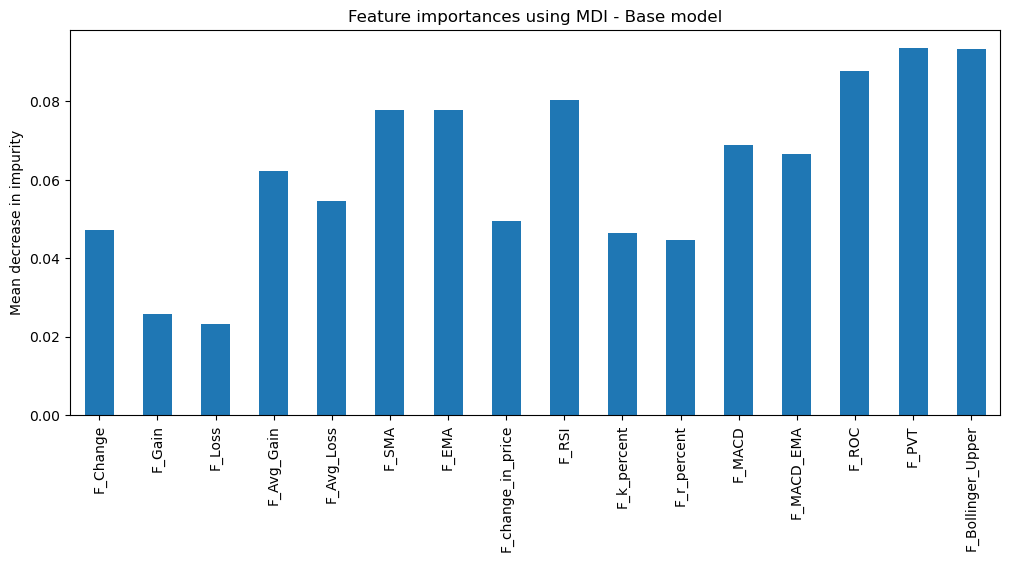

In [19]:
base_model = RandomForestClassifier(random_state=0)
base_grid, base_params, base_accuracy, col, base_prediction = best_grid_search(base_model, 'F', X_train, X_test, y_train, y_test)
print('Base model accuracy:', base_accuracy)

feature_names_base = col
importances_base = base_grid.feature_importances_

forest_importances_base = pd.Series(importances_base, index=feature_names_base)
      
fig, ax = plt.subplots(figsize=(12, 5))
forest_importances_base.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI - Base model")
ax.set_ylabel("Mean decrease in impurity")
plt.show()

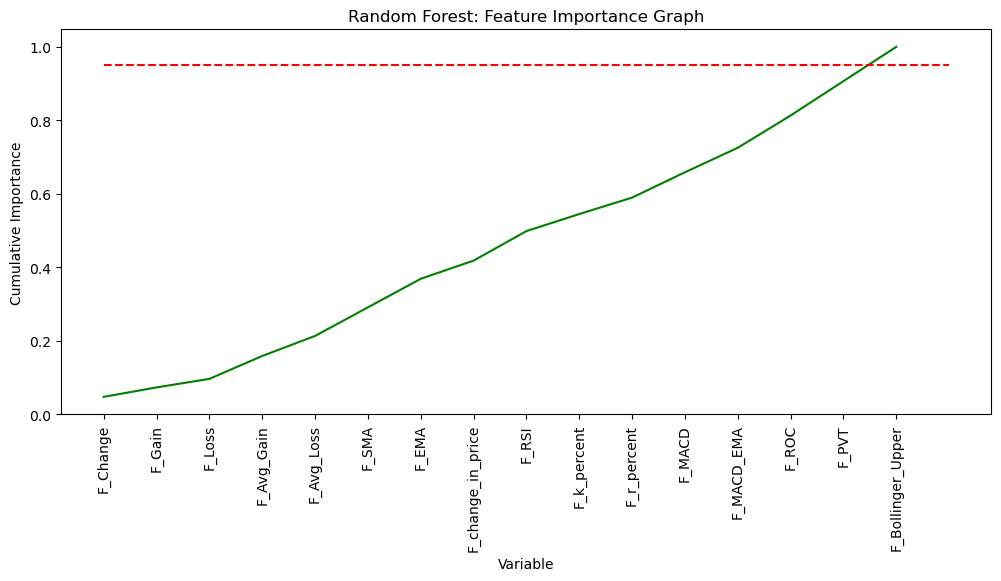

In [20]:
x_values = list(range(len(importances_base)))
cumulative_importances = np.cumsum(forest_importances_base.values)

plt.figure(figsize=(12,5))
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(forest_importances_base), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, forest_importances_base.index, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')
plt.show()

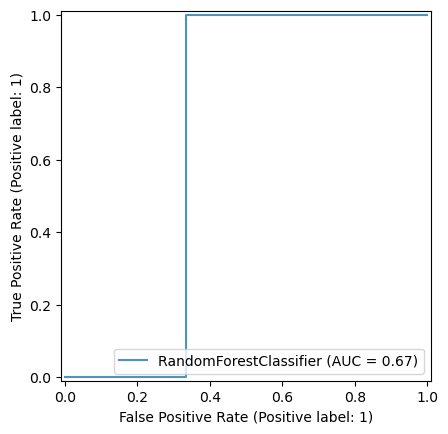

In [21]:
base_disp = RocCurveDisplay.from_estimator(base_grid, X_test[feature_names_base], y_test, alpha = 0.8)
plt.show()

## Multiple tickers

CADUSD=X:
Best: 0.600000 using {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
Best Grid search model for F and CADUSD=X accuracy: 0.6000000000000001
Improvement of -11.76%.


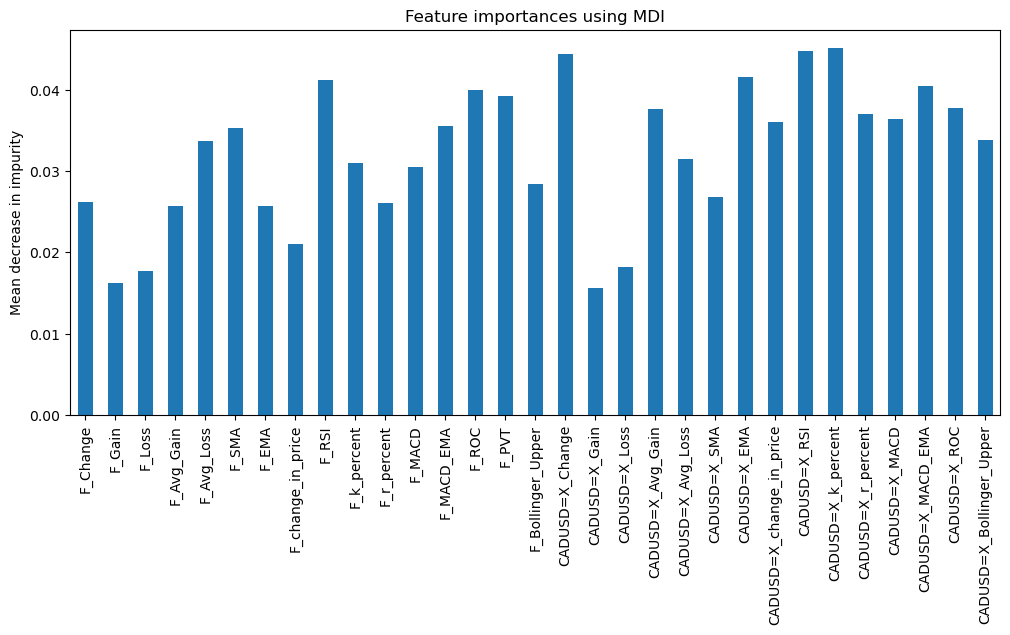

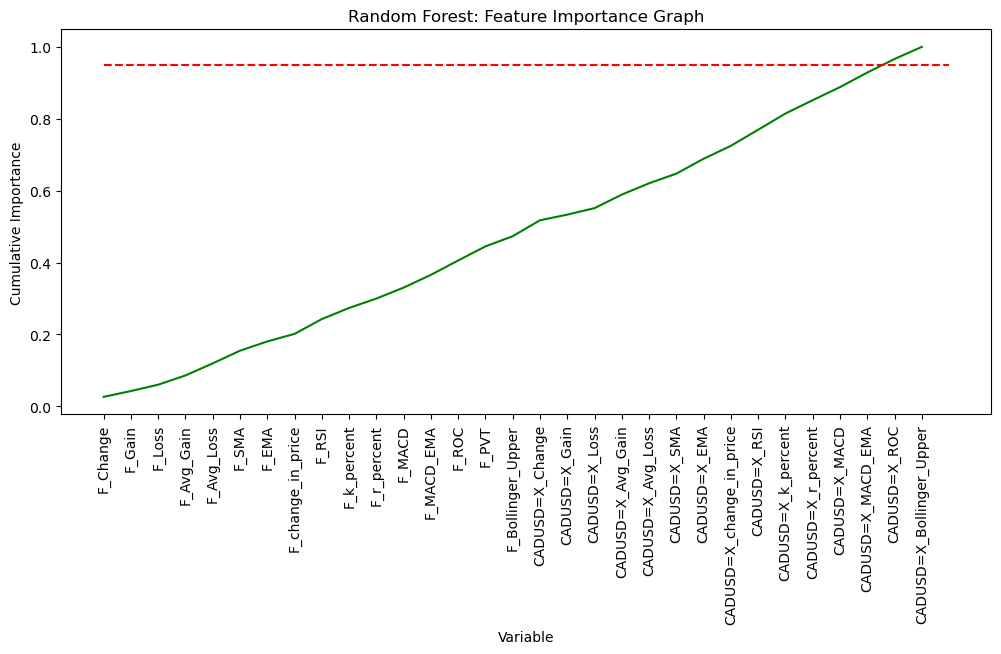

GM:
Best: 0.620000 using {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}
Best Grid search model for F and GM accuracy: 0.62
Improvement of -8.82%.


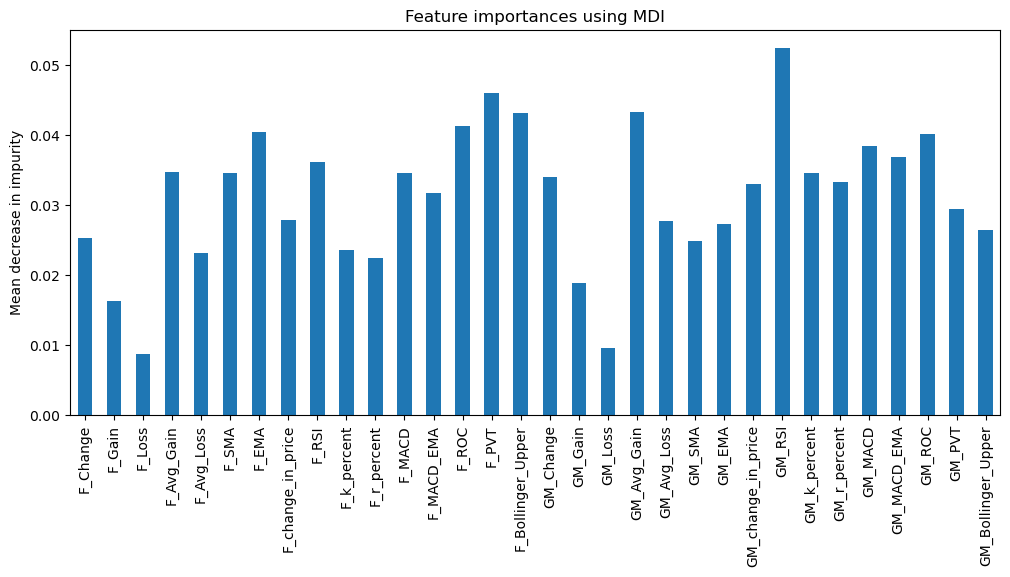

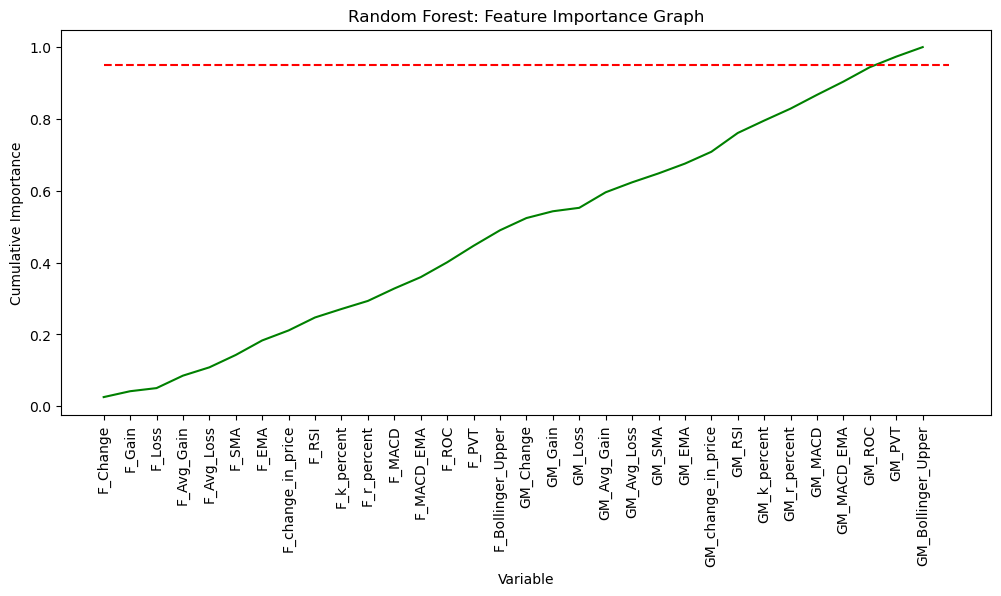

JCI:
Best: 0.640000 using {'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100}
Best Grid search model for F and JCI accuracy: 0.64
Improvement of -5.88%.


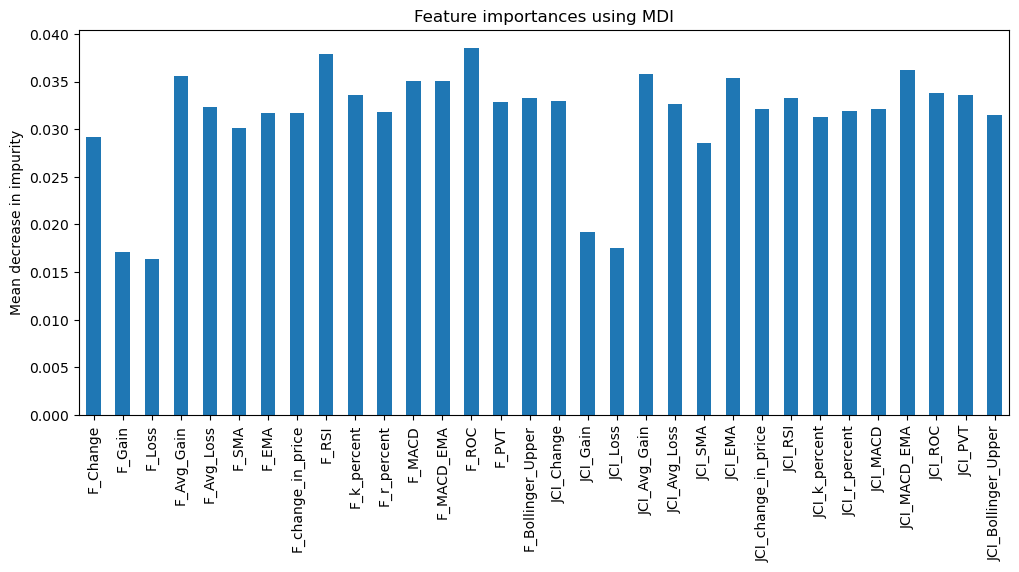

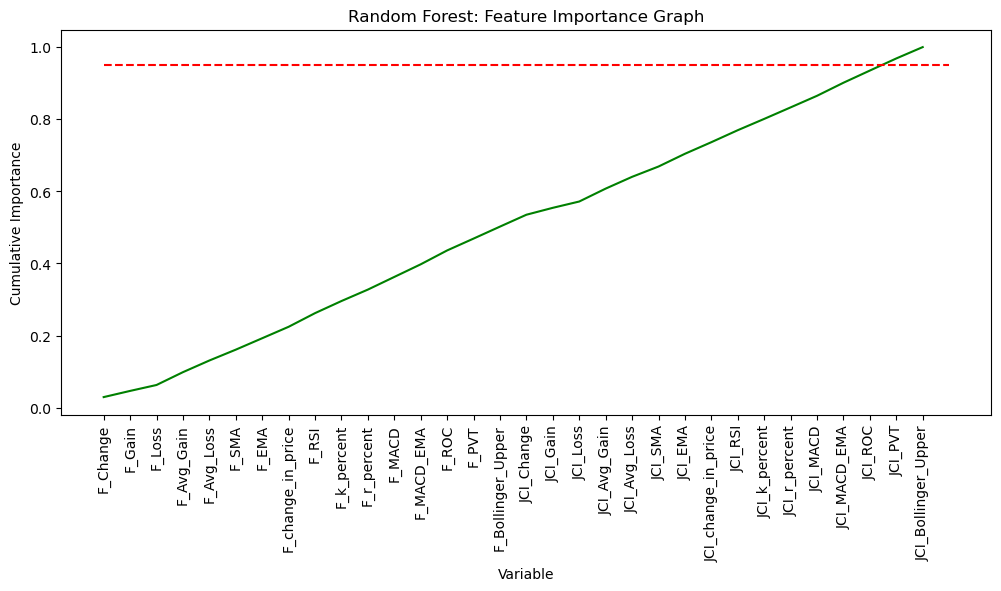

TM:
Best: 0.580000 using {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
Best Grid search model for F and TM accuracy: 0.58
Improvement of -14.71%.


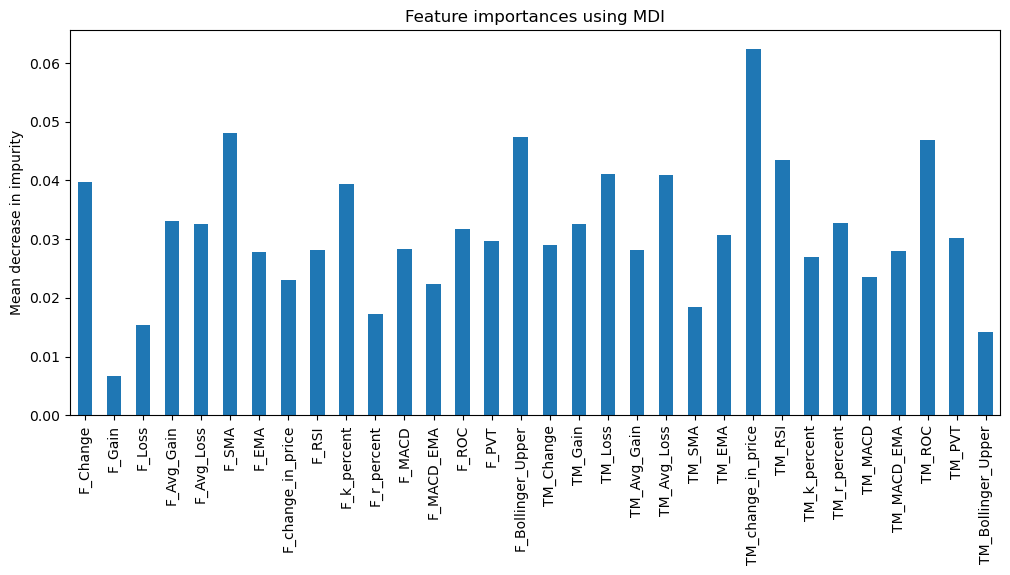

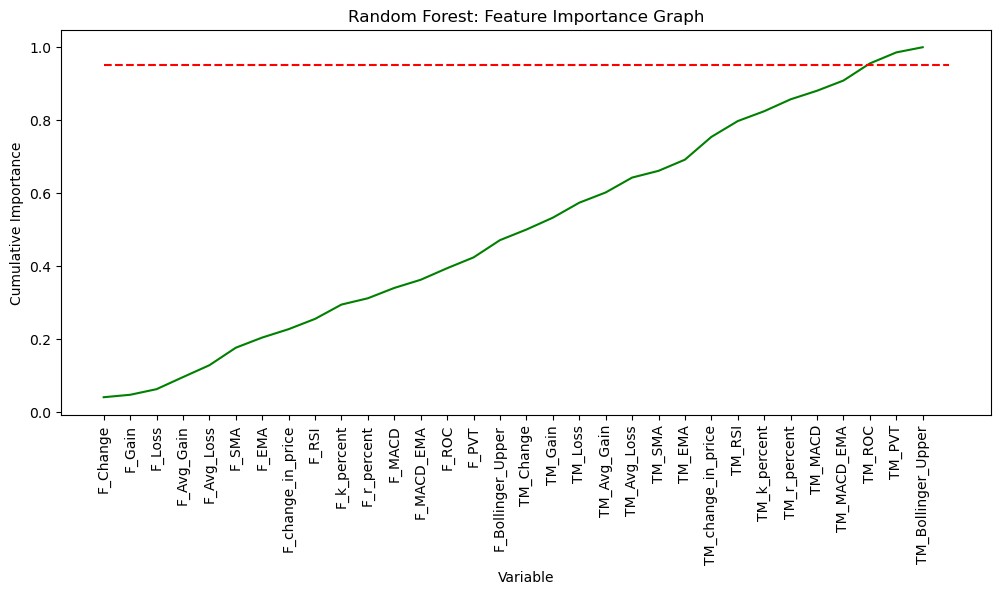

TRYUSD=X:
Best: 0.620000 using {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
Best Grid search model for F and TRYUSD=X accuracy: 0.62
Improvement of -8.82%.


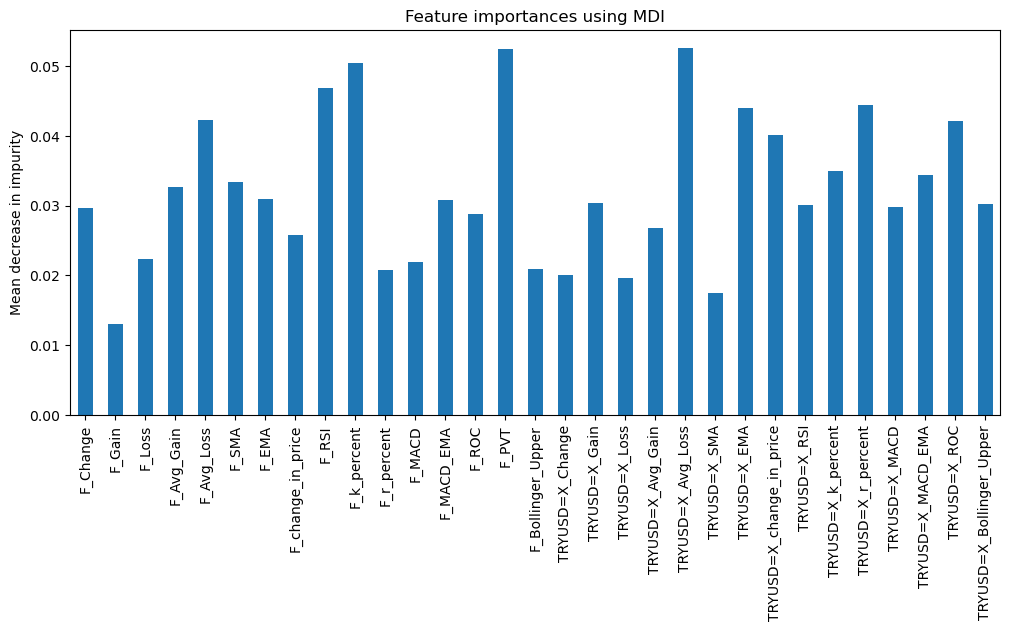

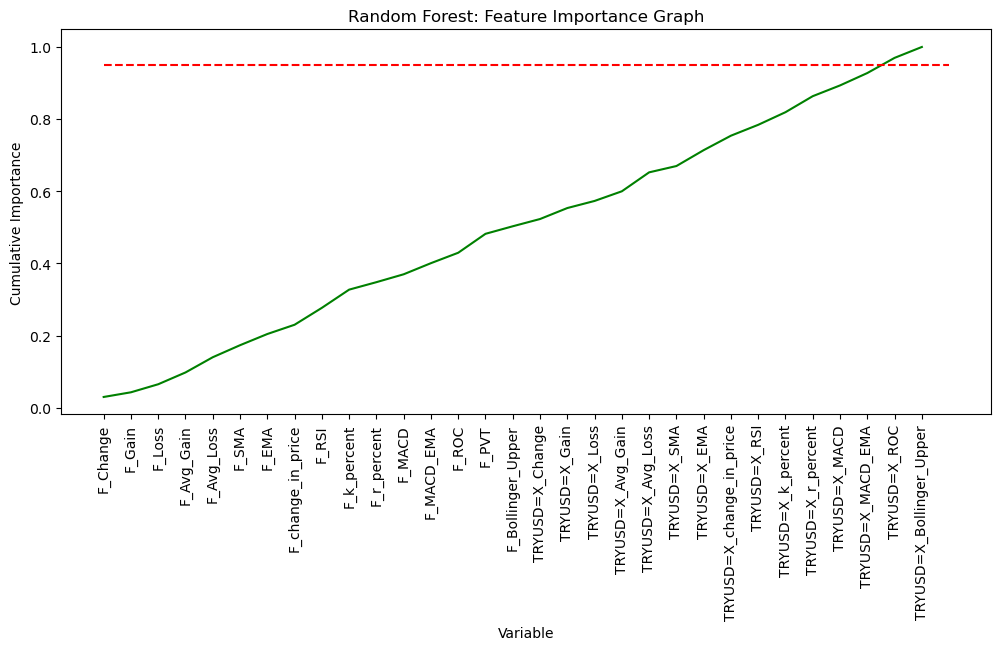

^IXIC:
Best: 0.660000 using {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 100}
Best Grid search model for F and ^IXIC accuracy: 0.6599999999999999
Improvement of -2.94%.


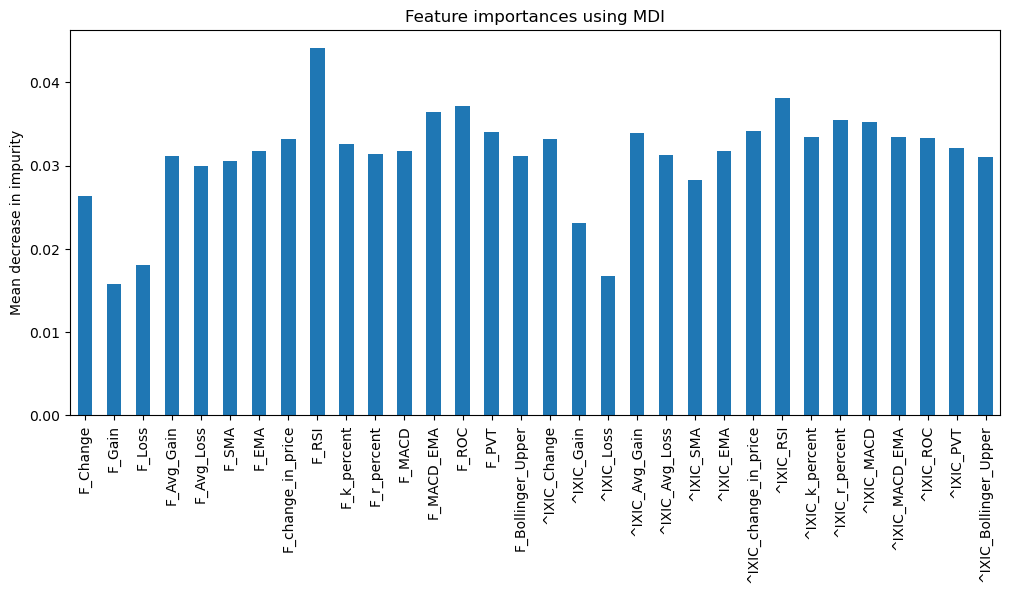

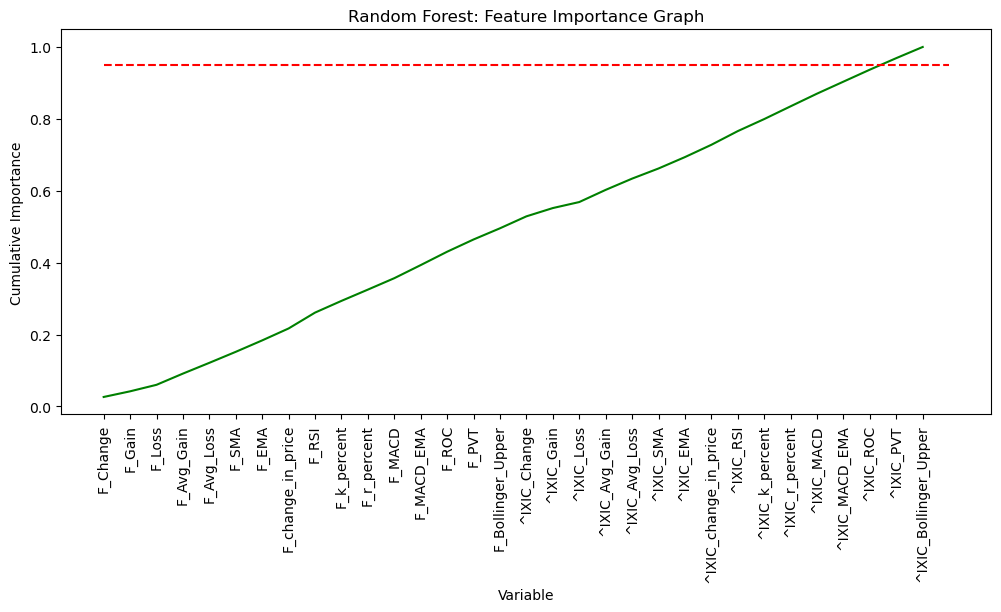

In [22]:
best_grid = {}
best_params = {}
best_accuracy = {}
improvement = {}
#cv_results = {}
cols = {}
prediction = {}

for t in tickers:
    # Create a random forest model
    rf = RandomForestClassifier(random_state=0)

    print(t + ':')
    
    best_grid[t], best_params[t], best_accuracy[t], cols[t], prediction[t] = best_grid_search(rf, t, X_train, X_test, y_train, y_test)
    #best_grid[t], best_params[t], cv_results[t], cols[t] = best_grid_search(rf, t, X_train, X_test, y_train, y_test)

    improvement[t] = 100 * (best_accuracy[t] - base_accuracy) / base_accuracy

    
    print('Best Grid search model for F and ' + t + ' accuracy:', best_accuracy[t]) 
    print('Improvement of {:0.2f}%.'.format(improvement[t]))

    feature_names = cols[t]
    importances = best_grid[t].feature_importances_

    forest_importances = pd.Series(importances, index=feature_names)
      
    fig, ax = plt.subplots(figsize=(12, 5))
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    plt.show()

    x_values = list(range(len(importances)))
    cumulative_importances = np.cumsum(forest_importances.values)

    plt.figure(figsize=(12,5))
    plt.plot(x_values, cumulative_importances, 'g-')
    # Draw line at 95% of importance retained
    plt.hlines(y = 0.95, xmin = 0, xmax = len(forest_importances), color = 'r', linestyles = 'dashed')
    # Format x ticks and labels
    plt.xticks(x_values, forest_importances.index, rotation = 'vertical')
    # Axis labels and title
    plt.xlabel('Variable')
    plt.ylabel('Cumulative Importance')
    plt.title('Random Forest: Feature Importance Graph')
    plt.show()

In [23]:
best_grid['CADUSD=X'].feature_importances_

array([0.02622233, 0.01616628, 0.01769588, 0.02567682, 0.03365875,
       0.03526307, 0.02570708, 0.02106246, 0.04113173, 0.03103884,
       0.02604972, 0.03052177, 0.03549703, 0.03997849, 0.03920152,
       0.02836428, 0.04434263, 0.0155892 , 0.01817083, 0.03762475,
       0.03152617, 0.02677778, 0.0415103 , 0.03596328, 0.04472956,
       0.04509161, 0.03706093, 0.03643506, 0.04050597, 0.03768798,
       0.03374791])

In [24]:
best_grid['Base'] = base_grid
best_accuracy['Base'] = base_accuracy
best_params['Base'] = base_params
prediction['Base'] = base_prediction
cols['Base'] = 'Base'

In [25]:
best_params

{'CADUSD=X': {'bootstrap': True,
  'criterion': 'gini',
  'max_depth': 10,
  'n_estimators': 20},
 'GM': {'bootstrap': False,
  'criterion': 'entropy',
  'max_depth': 10,
  'n_estimators': 80},
 'JCI': {'bootstrap': True,
  'criterion': 'gini',
  'max_depth': 20,
  'n_estimators': 100},
 'TM': {'bootstrap': True,
  'criterion': 'entropy',
  'max_depth': 5,
  'n_estimators': 20},
 'TRYUSD=X': {'bootstrap': True,
  'criterion': 'entropy',
  'max_depth': 5,
  'n_estimators': 20},
 '^IXIC': {'bootstrap': True,
  'criterion': 'entropy',
  'max_depth': 20,
  'n_estimators': 100},
 'Base': {'bootstrap': False,
  'criterion': 'gini',
  'max_depth': 10,
  'n_estimators': 100}}

## Compare different ticker marks

In [26]:
c = ['Ticker', 'n_estimators', 'max_depth', 'bootstrap', 'criterion', 'accuracy', 'improvement']
RF = pd.DataFrame(columns=c)

In [27]:
RF

Empty DataFrame
Columns: [Ticker, n_estimators, max_depth, bootstrap, criterion, accuracy, improvement]
Index: []

In [28]:
tickers.append('Base')
tickers

['CADUSD=X', 'GM', 'JCI', 'TM', 'TRYUSD=X', '^IXIC', 'Base']

In [29]:
for i, t in enumerate(tickers):
    RF.loc[i, 'Ticker'] = t

In [30]:
for i, t in enumerate(tickers):
    for j, c in enumerate(RF.columns[1:5]):
        RF.iloc[i, j + 1] = best_params[t][c]
    RF.loc[i, 'accuracy'] = best_accuracy[t]
    RF.loc[i, 'improvement'] = 100 * (best_accuracy[t] - base_accuracy) / base_accuracy

In [31]:
RF

Ticker n_estimators max_depth bootstrap criterion accuracy improvement
0  CADUSD=X           20        10      True      gini      0.6  -11.764706
1        GM           80        10     False   entropy     0.62   -8.823529
2       JCI          100        20      True      gini     0.64   -5.882353
3        TM           20         5      True   entropy     0.58  -14.705882
4  TRYUSD=X           20         5      True   entropy     0.62   -8.823529
5     ^IXIC          100        20      True   entropy     0.66   -2.941176
6      Base          100        10     False      gini     0.68         0.0

## Retrain the best model on entire training set

In [32]:
for i, t in enumerate(tickers):
    X_tr, X_t, y_tr, y_t = extract_train_test_set(X_train, X_test, y_train, y_test, t)
    model = best_grid[t]
    model.fit(X_tr, y_tr)
    print(t)
    print('Training accuracy: %f', accuracy_score(model.predict(X_tr), y_tr))
    print('Testing accuracy: %f', accuracy_score(model.predict(X_t), y_t))
    print('-------------------')

CADUSD=X
Training accuracy: %f 0.963474025974026
Testing accuracy: %f 0.6
-------------------
GM
Training accuracy: %f 0.877435064935065
Testing accuracy: %f 0.4
-------------------
JCI
Training accuracy: %f 1.0
Testing accuracy: %f 0.4
-------------------
TM
Training accuracy: %f 0.7037337662337663
Testing accuracy: %f 0.4
-------------------
TRYUSD=X
Training accuracy: %f 0.7248376623376623
Testing accuracy: %f 0.4
-------------------
^IXIC
Training accuracy: %f 1.0
Testing accuracy: %f 0.4
-------------------
Base
Training accuracy: %f 0.9375
Testing accuracy: %f 0.6
-------------------


## Backtesting

In [33]:
size = len(df) // 10
rng = np.random.RandomState(443)
forecast_length = 5
for j in range(10):
    m = rng.randint(j*size + forecast_length, (j + 1)*size - forecast_length)
    print(m)

30
240
349
392
540
715
786
882
1039
1119


In [34]:
df

Date  CADUSD=X_Change  CADUSD=X_Gain  \
0     2019-11-26 00:00:00+00:00        -0.000418       0.000000   
1     2019-11-27 00:00:00+00:00         0.001932       0.001932   
2     2019-11-29 00:00:00+00:00        -0.000607       0.000000   
3     2019-12-02 00:00:00+00:00        -0.000238       0.000000   
4     2019-12-03 00:00:00+00:00        -0.001081       0.000000   
...                         ...              ...            ...   
1232  2024-10-22 00:00:00+00:00        -0.001776       0.000000   
1233  2024-10-23 00:00:00+00:00         0.000905       0.000905   
1234  2024-10-24 00:00:00+00:00        -0.001072       0.000000   
1235  2024-10-25 00:00:00+00:00        -0.000866       0.000000   
1236  2024-10-28 00:00:00+00:00        -0.002197       0.000000   

      CADUSD=X_Loss  CADUSD=X_Avg_Gain  CADUSD=X_Avg_Loss  CADUSD=X_SMA  \
0          0.000418           0.000289           0.000910      0.756581   
1          0.000000           0.000427           0.000767      0.756063   
2          0.000607           0.000427           0.000641      0.755736   
3          0.000238           0.000419           0.000658      0.755404   
4          0.001081           0.000419           0.000707      0.754937   
...             ...                ...                ...           ...   
1232       0.001776           0.000308           0.001477      0.733303   
1233       0.000000           0.000245           0.001477      0.732536   
1234       0.001072           0.000245           0.001513      0.731416   
1235       0.000866           0.000245           0.001406      0.730423   
1236       0.002197           0.000245           0.001293      0.729302   

      CADUSD=X_EMA  CADUSD=X_change_in_price  CADUSD=X_RSI  ...  \
0         0.756180                 -0.000418     27.821853  ...   
1         0.755938                  0.001932     42.880806  ...   
2         0.755661                 -0.000607     39.864127  ...   
3         0.755387                 -0.000238     38.634678  ...   
4         0.755037                 -0.001081     33.260985  ...   
...            ...                       ...           ...  ...   
1232      0.730472                 -0.001776     22.129881  ...   
1233      0.729835                  0.000905     28.290869  ...   
1234      0.729157                 -0.001072     25.529720  ...   
1235      0.728461                 -0.000866     23.401396  ...   
1236      0.727622                 -0.002197     18.810221  ...   

      F_change_in_price      F_RSI  F_k_percent  F_r_percent    F_MACD  \
0              0.010000  62.087549    73.913071   -26.086929  0.006892   
1              0.090000  67.610216    89.583482   -10.416518  0.019164   
2             -0.040000  62.910674    81.250149   -18.749851  0.025755   
3             -0.050000  57.178300    70.833433   -29.166567  0.027163   
4             -0.120000  45.657569    45.833433   -54.166567  0.019687   
...                 ...        ...          ...          ...       ...   
1232           0.230000  63.192190    91.764633    -8.235367  0.063288   
1233          -0.049999  59.825069    80.219848   -19.780152  0.071755   
1234           0.179999  67.105734    98.850548    -1.149452  0.091931   
1235          -0.170000  56.038726    72.631549   -27.368451  0.093129   
1236           0.300000  67.090123    97.894690    -2.105310  0.116938   

      F_MACD_EMA     F_ROC         F_PVT  F_Bollinger_Upper  Prediction  
0       0.002249 -0.331855  2.394865e+06           9.188927           1  
1       0.005663  0.220269  2.768411e+06           9.183159           0  
2       0.009711  0.221244  2.710846e+06           9.165730           0  
3       0.013223  2.270145  2.505366e+06           9.172619           0  
4       0.014522  1.137661  1.963927e+06           9.166840           1  
...          ...       ...           ...                ...         ...  
1232    0.007636  6.315788  6.779642e+07          11.195281           0  
1233    0.020460  4.635769  6.76283

In [35]:
for t in best_grid:
    print(t)

CADUSD=X
GM
JCI
TM
TRYUSD=X
^IXIC
Base


In [36]:
def backtest(forecast_length=5):
    size = len(df) // 10
    rng = np.random.RandomState(443)
    acc_backtest = {}

    for t in best_grid:
        if t == 'Base':
            backtest = extract_cols(df, 'F')
        else:
            backtest = extract_cols(df, t)
        acc_backtest[t] = []
        y_backtest = backtest['Prediction'].copy()
        X_backtest = backtest.drop(['Prediction'], axis = 1).copy()
        model = best_grid[t]
        for j in range(10):
            m = rng.randint(j*size + forecast_length, (j + 1)*size - forecast_length)
            y_b = y_backtest[m: m + forecast_length]
            X_b = X_backtest[m: m + forecast_length]
            acc_backtest[t].append(accuracy_score(model.predict(X_b), y_b))

    return acc_backtest

In [37]:
acc_backtest_1 = backtest(1)
acc_backtest_2 = backtest(2)
acc_backtest_3 = backtest(3)
acc_backtest_4 = backtest(4)
acc_backtest_5 = backtest(5)

In [38]:
acc_backtest_1

{'CADUSD=X': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'GM': [1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0],
 'JCI': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'TM': [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0],
 'TRYUSD=X': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 '^IXIC': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'Base': [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]}

In [39]:
c = ['Ticker']
for i in range(1, 6):
    s = 'n = ' + str(i)
    c.append(s)

acc_backtest_mean = pd.DataFrame(columns=c)

for i, t in enumerate(best_grid):
    acc_backtest_mean.loc[i, 'Ticker'] = t
    
acc_backtest_mean
acc_backtest_std = acc_backtest_mean.copy()

In [40]:
acc_backtest_mean

Ticker n = 1 n = 2 n = 3 n = 4 n = 5
0  CADUSD=X   NaN   NaN   NaN   NaN   NaN
1        GM   NaN   NaN   NaN   NaN   NaN
2       JCI   NaN   NaN   NaN   NaN   NaN
3        TM   NaN   NaN   NaN   NaN   NaN
4  TRYUSD=X   NaN   NaN   NaN   NaN   NaN
5     ^IXIC   NaN   NaN   NaN   NaN   NaN
6      Base   NaN   NaN   NaN   NaN   NaN

In [41]:
for i, t in enumerate(acc_backtest_1):
    acc_backtest_mean.loc[i, 'n = 1'] = np.mean(acc_backtest_1[t])
    acc_backtest_mean.loc[i, 'n = 2'] = np.mean(acc_backtest_2[t])
    acc_backtest_mean.loc[i, 'n = 3'] = np.mean(acc_backtest_3[t])
    acc_backtest_mean.loc[i, 'n = 4'] = np.mean(acc_backtest_4[t])
    acc_backtest_mean.loc[i, 'n = 5'] = np.mean(acc_backtest_5[t])

    acc_backtest_std.loc[i, 'n = 1'] = np.std(acc_backtest_1[t])
    acc_backtest_std.loc[i, 'n = 2'] = np.std(acc_backtest_2[t])
    acc_backtest_std.loc[i, 'n = 3'] = np.std(acc_backtest_3[t])
    acc_backtest_std.loc[i, 'n = 4'] = np.std(acc_backtest_4[t])
    acc_backtest_std.loc[i, 'n = 5'] = np.std(acc_backtest_5[t])

In [42]:
acc_backtest_mean

Ticker n = 1 n = 2     n = 3  n = 4 n = 5
0  CADUSD=X   1.0  0.95  0.933333   0.95  0.96
1        GM   0.8   1.0  0.933333    0.9   0.9
2       JCI   1.0   1.0       1.0    1.0   1.0
3        TM   0.5   0.5       0.8  0.825  0.78
4  TRYUSD=X   1.0  0.75  0.566667  0.675  0.68
5     ^IXIC   1.0   1.0       1.0    1.0   1.0
6      Base   0.8   1.0  0.966667  0.825  0.92

In [43]:
acc_backtest_std

Ticker n = 1     n = 2     n = 3     n = 4     n = 5
0  CADUSD=X   0.0      0.15  0.133333       0.1      0.08
1        GM   0.4       0.0  0.133333  0.165831  0.134164
2       JCI   0.0       0.0       0.0       0.0       0.0
3        TM   0.5  0.387298  0.221108  0.195256  0.166132
4  TRYUSD=X   0.0   0.33541  0.260342  0.195256      0.16
5     ^IXIC   0.0       0.0       0.0       0.0       0.0
6      Base   0.4       0.0       0.1     0.225  0.132665

## Plot accuracy of backtest

In [44]:
x = [i + 1 for i in range(5)]
mean_df = acc_backtest_mean.drop('Ticker', axis=1).copy()
std_df = acc_backtest_std.drop('Ticker', axis=1).copy()

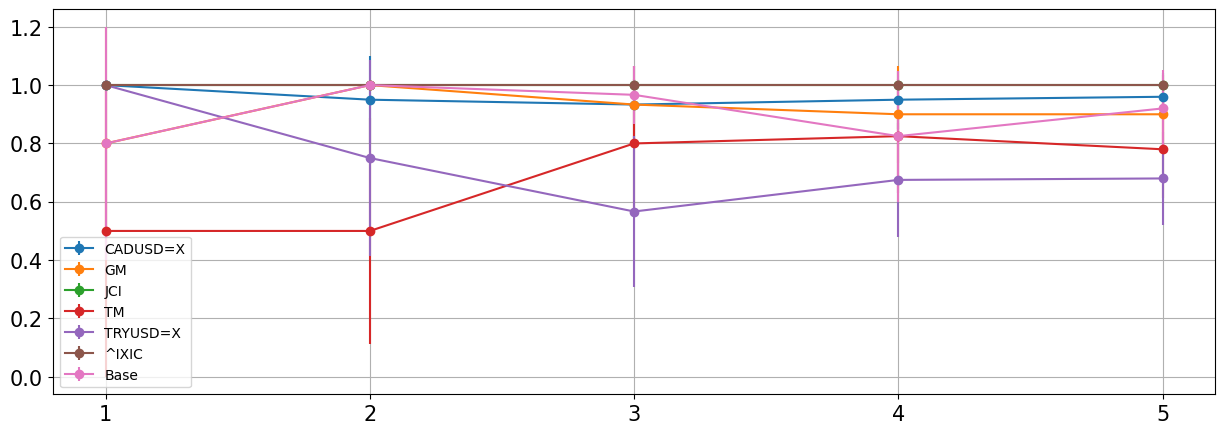

In [45]:
x = [i + 1 for i in range(5)]

plt.figure(figsize=(15,5))
for i in range(len(mean_df)):
    t = acc_backtest_mean.loc[i, 'Ticker']
    m = mean_df.iloc[i].to_numpy()
    s = std_df.iloc[i].to_numpy()
    plt.errorbar(x, m, s, marker='o', label=t)
plt.legend()
plt.xticks(x, fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.show()

In [49]:
acc_backtest_1_df = pd.DataFrame(acc_backtest_1)
acc_backtest_1_df

CADUSD=X   GM  JCI   TM  TRYUSD=X  ^IXIC  Base
0       1.0  1.0  1.0  0.0       1.0    1.0   1.0
1       1.0  0.0  1.0  1.0       1.0    1.0   1.0
2       1.0  1.0  1.0  0.0       1.0    1.0   1.0
3       1.0  1.0  1.0  0.0       1.0    1.0   0.0
4       1.0  1.0  1.0  1.0       1.0    1.0   1.0
5       1.0  1.0  1.0  1.0       1.0    1.0   1.0
6       1.0  1.0  1.0  1.0       1.0    1.0   1.0
7       1.0  0.0  1.0  1.0       1.0    1.0   1.0
8       1.0  1.0  1.0  0.0       1.0    1.0   1.0
9       1.0  1.0  1.0  0.0       1.0    1.0   0.0

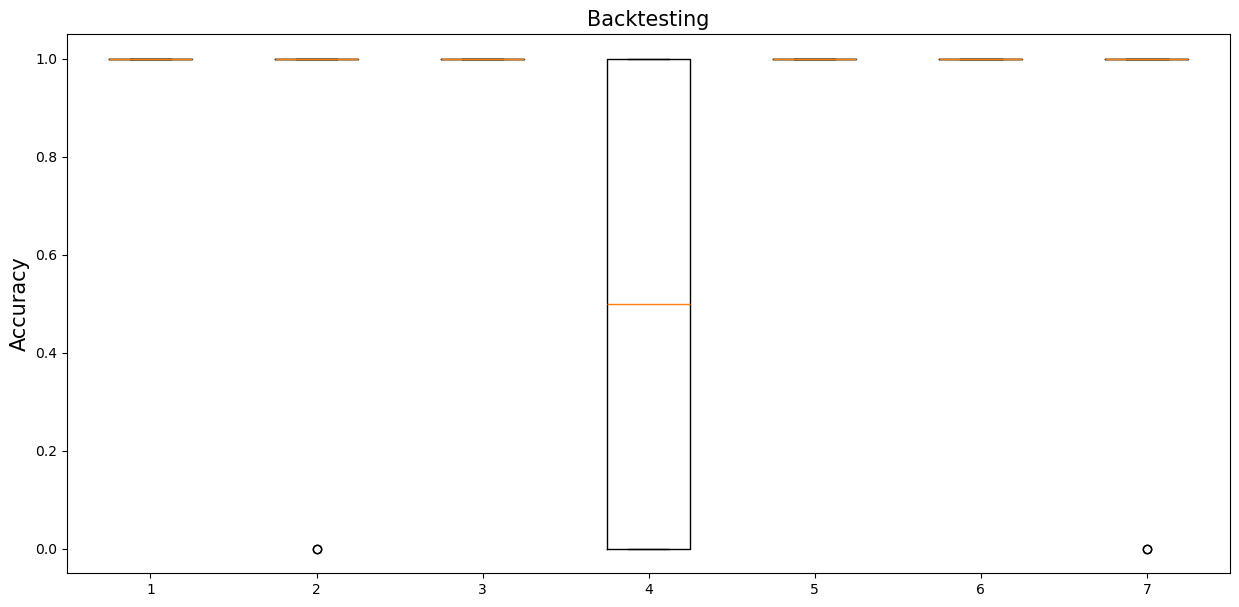

In [50]:
plt.figure(figsize = (15, 7))
plt.boxplot(acc_backtest_1_df)
#plt.xticks(x_col, label_col)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Backtesting', fontsize = 15)
plt.show()